In [2]:
!pip install -r ./requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.2 MB/s eta 0:00:00
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 6.3 MB/s eta 0:00:00
  Using cached pillow-10.3.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 16.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 11.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import gym
import random
import numpy as np   
import matplotlib.pyplot as plt
import collections
import pygame

# Import Tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import load_model


#disable eager execution (optimization)
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# ###### Tensorflow-GPU ########
try:
  physical_devices = tf.config.experimental.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print("GPU found")
except:
  print("No GPU found")


2024-05-10 14:10:33.678629: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-10 14:10:33.696956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-10 14:10:33.696976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-10 14:10:33.697463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-10 14:10:33.700590: I tensorflow/core/platform/cpu_feature_guar

No GPU found


2024-05-10 14:10:34.393415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-10 14:10:34.408281: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



## environment


In [3]:
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)  # Car color
GREEN = (0, 255, 0)  # Goal



class RCMazeEnv(gym.Env):
    def __init__(self, maze_size_x=12, maze_size_y=12):
        self.maze_size_x = maze_size_x
        self.maze_size_y = maze_size_y
        self.maze = self.generate_maze()
        self.car_position = (1, 1)
        self.possible_actions = range(3)
        self.car_orientation = 'E'
        self.sensor_readings = {'front': 0, 'left': 0, 'right': 0}
        self.steps = 0
        self.previous_steps = 0
        self.previous_distance = 0
        self.goal = (10, 10)
        self.visited_positions = set()
        self.reset()

        # Pygame initialization
        pygame.init()
        self.window_width = 600
        self.window_height = 600
        self.screen = pygame.display.set_mode((self.window_width, self.window_height))
        self.cell_width = self.window_width / maze_size_x
        self.cell_height = self.window_height / maze_size_y
        # pygame clock
        self.clock = pygame.time.Clock()
        pygame.display.set_caption("RC Maze Game")

        # Load assets
        self.car_image = self.load_image(
            "../textures/car.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.wall_image = self.load_image(
            "../textures/wall_center.png",
            int(self.cell_width),
            int(self.cell_height),
        )

        self.goal_image = self.load_image(
            "../textures/door_closed.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.floor_image = self.load_image(
            "../textures/floor_mud_e.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = self.load_image(
            "../textures/gargoyle_top_1.png",
            int(self.cell_width),
            int(self.cell_height),
        )
        self.top_of_wall = pygame.transform.rotate(self.top_of_wall, 180)

    def generate_maze(self):
        # For simplicity, create a static maze with walls
        # '1' represents a wall, and '0' represents an open path
        maze = np.zeros((self.maze_size_y, self.maze_size_x), dtype=int)
        # Add walls to the maze (this can be customized)

        layout = [
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1],
            [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1],
            [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1],
            [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        ]

        maze = np.array(layout)

        return maze

    def reset(self):
        self.car_position = (1, 1)
        self.car_orientation = 'E'
        self.update_sensor_readings()
        self.previous_steps = self.steps
        self.steps = 0
        self.previous_distance = 0
        self.visited_positions.clear()  # Clear the visited positions
        self.visited_positions.add(self.car_position)
        return self.get_state()

    def step(self, action):

        if action == 0:
            self.move_forward()
        elif action == 1:  # Turn left
            self.turn_left()
        elif action == 2:  # Turn right
            self.turn_right()

        self.update_sensor_readings()
        self.visited_positions.add(self.car_position)
        reward = self.compute_reward()
        self.steps += 1
        done = self.is_done()

        return self.get_state(), reward, done

    def move_forward(self):
        x, y = self.car_position

        # Check sensor reading in the direction of car's orientation
        if self.sensor_readings['front'] <= 4:
            # If the sensor reading is 4 or less, do not move forward
            return

        if self.car_orientation == 'N' and y > 0 and self.maze[y - 1][x] != 1:
            self.car_position = (x, y - 1)
        elif self.car_orientation == 'S' and y < self.maze_size_y - 1 and self.maze[y + 1][x] != 1:
            self.car_position = (x, y + 1)
        elif self.car_orientation == 'E' and x < self.maze_size_x - 1 and self.maze[y][x + 1] != 1:
            self.car_position = (x + 1, y)
        elif self.car_orientation == 'W' and x > 0 and self.maze[y][x - 1] != 1:
            self.car_position = (x - 1, y)

    def turn_left(self):
        orientations = ['N', 'W', 'S', 'E']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def turn_right(self):
        orientations = ['N', 'E', 'S', 'W']
        idx = orientations.index(self.car_orientation)
        self.car_orientation = orientations[(idx + 1) % 4]

    def update_sensor_readings(self):
        # Simple sensor implementation: counts steps to the nearest wall
        self.sensor_readings['front'] = self.distance_to_wall('front')
        self.sensor_readings['left'] = self.distance_to_wall('left')
        self.sensor_readings['right'] = self.distance_to_wall('right')

    def distance_to_wall(self, direction):
        x, y = self.car_position
        sensor_max_range = 255  # Maximum range of the ultrasonic sensor

        def calculate_distance(dx, dy):
            distance = 0
            while 0 <= x + distance * dx < self.maze_size_x and \
                0 <= y + distance * dy < self.maze_size_y and \
                self.maze[y + distance * dy][x + distance * dx] != 1:
                distance += 1
                if distance > sensor_max_range:  # Limiting the sensor range
                    break
            return distance

        if direction == 'front':
            if self.car_orientation == 'N':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'S':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'E':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'W':
                distance = calculate_distance(-1, 0)

        elif direction == 'left':
            if self.car_orientation == 'N':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, -1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, 1)

        elif direction == 'right':
            if self.car_orientation == 'N':
                distance = calculate_distance(1, 0)
            elif self.car_orientation == 'S':
                distance = calculate_distance(-1, 0)
            elif self.car_orientation == 'E':
                distance = calculate_distance(0, 1)
            elif self.car_orientation == 'W':
                distance = calculate_distance(0, -1)

        # Normalize the distance to a range of 0-1
        normalized_distance = distance / sensor_max_range
        normalized_distance = max(0, min(normalized_distance, 1))

        return normalized_distance * 1000

    def compute_reward(self):
        """
        Compute the reward based on the current state of the environment


        @return The reward to be added to the step function
        """
        # Initialize reward
        reward = 0

        # Check for collision or out of bounds
        # If the sensor is on the front left right or front side of the sensor is not on the board.
        if any(
            self.sensor_readings[direction] == 0
            for direction in ["front", "left", "right"]
        ):
            reward -= 20

        # Check if goal is reached
        # The reward of the goal.
        if self.car_position == self.goal:
            reward += 500
            # Additional penalty if it takes too many steps to reach the goal
            # If the reward is more than 1000 steps then the reward is decremented by 200.
            if self.steps > 1000:
                reward -= 200
            

        # Calculate the Euclidean distance to the goal
        distance_to_goal = (
            (self.car_position[0] - self.goal[0]) ** 2
            + (self.car_position[1] - self.goal[1]) ** 2
        ) ** 0.5

        # Define a maximum reward when the car is at the goal
        max_reward_at_goal = 50

        # Reward based on proximity to the goal
        reward += max_reward_at_goal / (
            distance_to_goal + 1
        )  # Adding 1 to avoid division by zero

        # # Reward or penalize based on movement towards or away from the goal
        # Move the reward to the goal
        if distance_to_goal < self.previous_distance:
            reward += 50  # Positive reward for moving closer to the goal
        elif distance_to_goal > self.previous_distance:
            reward -= 25  # Negative reward for moving farther from the goal

        # Apply a penalty to revisit the same position
        if self.car_position in self.visited_positions:
            # Apply a penalty for revisiting the same position
            reward -= 10

        # Penalize for each step taken to encourage efficiency
        reward -= 5

        # Update the previous_distance for the next step
        self.previous_distance = distance_to_goal
        return reward

    def is_done(self):
        # is done if it reaches the goal or goes out of bounds or takes more than 3000 steps
        return self.car_position == self.goal or self.steps > 3000 or self.car_position[0] < 0 or self.car_position[1] < 0 or self.car_position[0] > 11 or self.car_position[1] > 11

    def get_state(self):
        car_position = [float(coord) for coord in self.car_position]
        sensor_readings = [float(value) for value in self.sensor_readings.values()]

        state = car_position + [self.car_orientation] + sensor_readings

        # cast state to this ['1.0' '1.0' 'N' '1.0' '1.0' '10.0']
        state = np.array(state, dtype=str)

        # get the orientation and convert do label encoding
        if state[2] == 'N':
            state[2] = 0
        elif state[2] == 'E':
            state[2] = 1
        elif state[2] == 'S':
            state[2] = 2
        elif state[2] == 'W':
            state[2] = 3

        state = np.array(state, dtype=float)

        return state

    def load_image(self, image_path, width, height):
        image = pygame.image.load(image_path)
        image = pygame.transform.scale(image, (width, height))
        return image

    def draw_maze(self):
        for y in range(self.maze_size_y):
            for x in range(self.maze_size_x):
                if self.maze[y][x] == 1:
                    self.screen.blit(
                        self.wall_image, (x * self.cell_width, y * self.cell_height)
                    )

                    self.screen.blit(
                        self.top_of_wall, (x * self.cell_width, y * self.cell_height)
                    )
                    # add top of wall
                if self.maze[y][x] == 0:
                    self.screen.blit(
                        self.floor_image, (x * self.cell_width, y * self.cell_height)
                    )

    def draw_car(self):
        if self.car_orientation == "N":
            car_image = pygame.transform.rotate(self.car_image, 180)
        elif self.car_orientation == "E":
            car_image = pygame.transform.rotate(self.car_image, 90)
        elif self.car_orientation == "S":
            car_image = self.car_image
        elif self.car_orientation == "W":
            car_image = pygame.transform.rotate(self.car_image, 270)

        self.screen.blit(
            car_image,
            (
                self.car_position[0] * self.cell_width,
                self.car_position[1] * self.cell_height,
            ),
        )

    def draw_goal(self):
        self.screen.blit(
            self.goal_image,
            (self.goal[0] * self.cell_width, self.goal[1] * self.cell_height),
        )

    def render(self,render_mode='human', framerate=60, delay=0):
        if render_mode == 'human':
            self.draw_maze()
            self.draw_car()
            self.draw_goal()
            pygame.display.flip()
            self.clock.tick(framerate)  
        elif render_mode == 'rgb_array':
            rendered_maze = np.array(self.maze, dtype=str)
            x, y = self.car_position
            rendered_maze[y][x] = 'C'
            # print array
            print(rendered_maze, '\n')

    def close_pygame(self):
        # Close the Pygame window
        pygame.quit()

# DDQN

In [13]:
mse = tf.keras.losses.MeanSquaredError()
class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.policy_model = self.buildNetwork()
        self.target_model = self.buildNetwork()
        self.target_model.set_weights(self.policy_model.get_weights())

    def addToReplayMemory(self, step):
        self.step = step
        self.memory.append(self.step)

    def sampleFromReplayMemory(self, batchSize):
        self.batchSize = batchSize
        if self.batchSize > len(self.memory):
            self.populated = False
            return self.populated
        else:
            return random.sample(self.memory, self.batchSize)

    def buildNetwork(self):
        """
        Builds and compiles the neural network. This is a helper to allow subclasses to override the build method in order to add more features such as learning rate and loss.


        @return A Sequential object that can be used to train the
        """
        model = Sequential(
            [
                Input(shape=self.input_shape),
                Dense(32, activation="relu"),
                Dense(64, activation="relu"),
                Dense(32, activation="relu"),
                Dense(self.output_shape, activation="linear"),
            ]
        )
        model.compile(
            loss=mse,
            optimizer=Adam(learning_rate=self.learning_rate),
            metrics=["mean_squared_error"],  # Use the string identifier
        )
        return model

    def policy_network_fit(self, batch, batch_size):
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)

        # Predict Q-values for starting state using the policy network
        q_values = self.policy_model.predict(states)

        # Predict Q-values for next state using the policy network
        q_values_next_state_policy = self.policy_model.predict(next_states)

        # Select the best action for the next state using the policy network
        best_actions = np.argmax(q_values_next_state_policy, axis=1)

        # Predict Q-values for next state using the target network
        q_values_next_state_target = self.target_model.predict(next_states)

        # Update Q-values for actions taken
        for i in range(batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                # Double DQN update rule
                q_values[i, actions[i]] = rewards[i] + self.discount_factor * q_values_next_state_target[i, best_actions[i]]

        # Train the policy network
        History = self.policy_model.fit(states, q_values, batch_size=batch_size, verbose=0)
        return History

    def policy_network_predict(self, state):
        self.state = state
        self.qPolicy = self.policy_model.predict(self.state)
        return self.qPolicy

    def target_network_predict(self, state):
        self.state = state
        self.qTarget = self.target_model.predict(self.state)
        return self.qTarget

    def update_target_network(self):
        self.target_model.set_weights(self.policy_model.get_weights())

### training

In [14]:
env = RCMazeEnv()
state = env.reset()


# Model parameters
REPLAY_MEMORY_CAPACITY = 2000000
# MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
POSSIBLE_ACTIONS = env.possible_actions

# state = state[0]
# create DQN agent
agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                input_shape=state.shape, 
                output_shape=len(POSSIBLE_ACTIONS),
                learning_rate=0.001, 
                discount_factor=0.90)

# reset the parameters
DISCOUNT = 0.90
BATCH_SIZE = 128  # How many steps (samples) to use for training
UPDATE_TARGET_INTERVAL = 2
EPSILON = 0.99 # Exploration percentage
MIN_EPSILON = 0.01
DECAY = 0.99973
EPISODE_AMOUNT = 175

# Fill the replay memory with the first batch of samples
update_counter = 0
reward_history = []
epsilon_history = []
loss_history = []
epsilon_history = []
mse_history = []

# step history for each episode
episode_path_history = []
step_history = []
action_history = []

np.set_printoptions(precision=3, suppress=True)

for episode in range(EPISODE_AMOUNT):
    episode_reward = 0
    step_counter = 0  # count the number of successful steps within the episode

    state = env.reset()
    done = False
    epsilon_history.append(EPSILON)

    while not done:
        env.render(delay=0, framerate=720)

        if random.random() <= EPSILON:
            action = random.sample(POSSIBLE_ACTIONS, 1)[0]
        else:
            qValues = agent.policy_network_predict(state.reshape(1,-1))
            action = np.argmax(qValues[0])
            
        # add the action to the action history
        action_history.append((episode, action))

        new_state, reward, done = env.step(action)

        step_counter +=1

        # store step in replay memory
        step = (state, action, reward, new_state, done)
        agent.addToReplayMemory(step)
        # add the current car position to the episode path history with the episode number
        episode_path_history.append((episode, env.car_position))
        
        
        state = new_state
        episode_reward += reward
        # When enough steps in replay memory -> train policy network
        if len(agent.memory) >= (BATCH_SIZE):
            EPSILON = DECAY * EPSILON
            if EPSILON < MIN_EPSILON:
                EPSILON = MIN_EPSILON
            # sample minibatch from replay memory

            miniBatch = agent.sampleFromReplayMemory(BATCH_SIZE)
            miniBatch_states = np.asarray(list(zip(*miniBatch))[0],dtype=float)
            miniBatch_actions = np.asarray(list(zip(*miniBatch))[1], dtype = int)
            miniBatch_rewards = np.asarray(list(zip(*miniBatch))[2], dtype = float)
            miniBatch_next_state = np.asarray(list(zip(*miniBatch))[3],dtype=float)
            miniBatch_done = np.asarray(list(zip(*miniBatch))[4],dtype=bool)

            # current state q values1tch_states)
            y = agent.policy_network_predict(miniBatch_states)

            next_state_q_values = agent.target_network_predict(miniBatch_next_state)
            max_q_next_state = np.max(next_state_q_values,axis=1)

            for i in range(BATCH_SIZE):
                if miniBatch_done[i]:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i]
                else:
                    y[i,miniBatch_actions[i]] = miniBatch_rewards[i] + DISCOUNT *  max_q_next_state[i]

            # fit model
            history = agent.policy_network_fit(miniBatch, BATCH_SIZE)

            loss_history.append(history.history['loss'])
            mse_history.append(history.history["mean_squared_error"])

        else:
            continue
        if update_counter == UPDATE_TARGET_INTERVAL:
            agent.update_target_network()
            update_counter = 0
        update_counter += 1
    print('episodeReward for episode ', episode, '= ', episode_reward, 'with epsilon = ', EPSILON, 'and steps = ', step_counter)
    step_history.append(step_counter)
    reward_history.append(episode_reward)


env.close_pygame()
env.close()

2024-05-10 12:50:14.208312: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_38/bias/Assign' id:152654 op device:{requested: '', assigned: ''} def:{{{node dense_38/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_38/bias, dense_38/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


KeyboardInterrupt: 

In [ ]:
env.close_pygame()

### results

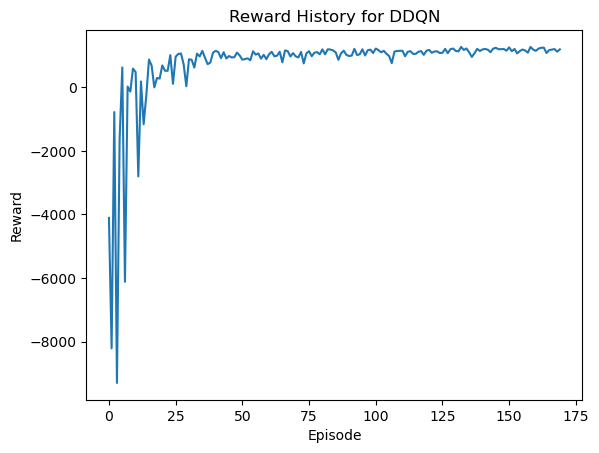

In [ ]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for DDQN")
plt.savefig('../images/training_images/reward_history_DDQN.png')
plt.show()
# save the image

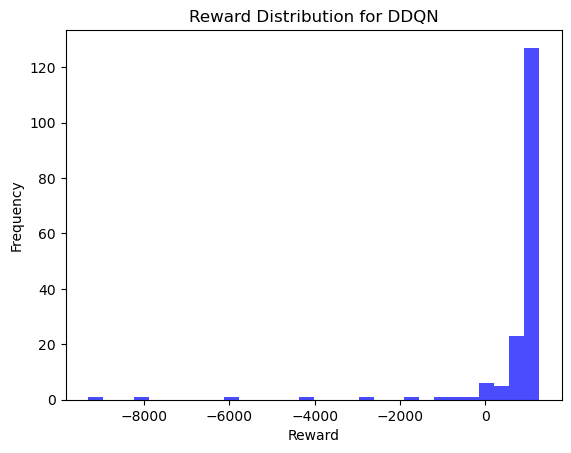

In [ ]:
def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.savefig("../images/training_images/reward_distribution_DDQN.png")
    plt.show()
    # save the image


# Example usage:
# Assuming `rewards` is a list of total rewards per episode.
# plot_reward_distribution(rewards)
plot_reward_distribution(reward_history, title="Reward Distribution for DDQN")

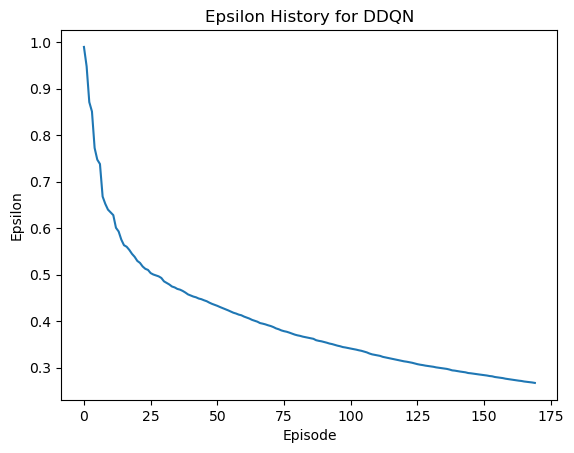

In [ ]:
# plot epsilon over time
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon History for DDQN")
plt.savefig("../images/training_images/epsilon_history_DDQN.png")
plt.show()
# save the image

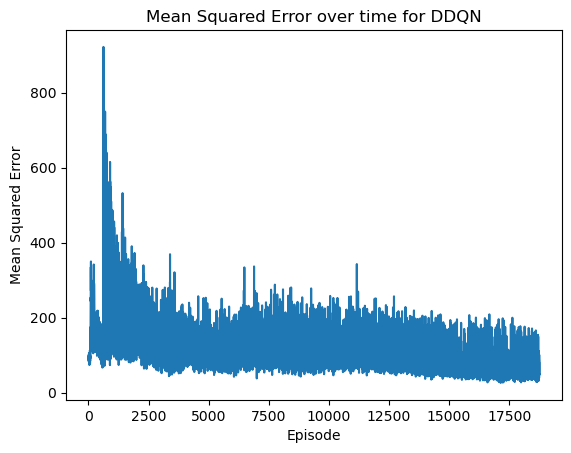

In [ ]:
# evalution

# plot mse
plt.plot(mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time for DDQN")
plt.savefig("../images/training_images/mse_history_DDQN.png")
plt.show()
# save the image

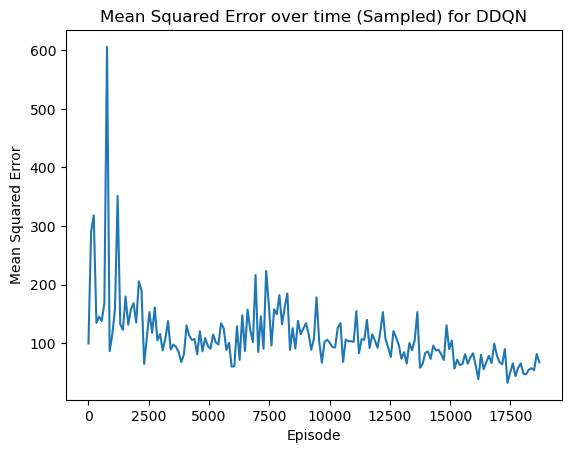

In [ ]:
# Assuming mse_history is a flat list with the correct number of elements
EPISODE_AMOUNT = len(mse_history)  # Make sure this reflects the actual number of episodes
desired_samples = 170  # The number of points you want to plot

# Calculate the step size
step = max(EPISODE_AMOUNT // desired_samples, 1)  # Avoid division by zero
sampled_mse_history = mse_history[::step]

# Ensure sampled_episodes has the same number of elements as sampled_mse_history
sampled_episodes = list(range(0, EPISODE_AMOUNT, step))[:len(sampled_mse_history)]

plt.plot(sampled_episodes, sampled_mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time (Sampled) for DDQN")
plt.savefig("../images/training_images/mse_history_sampled_DDQN.png")
plt.show()
# save the image

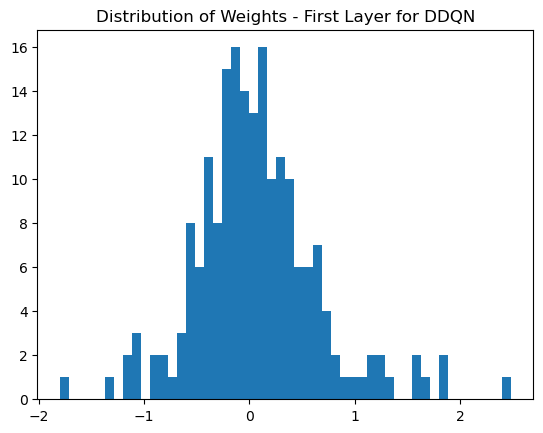

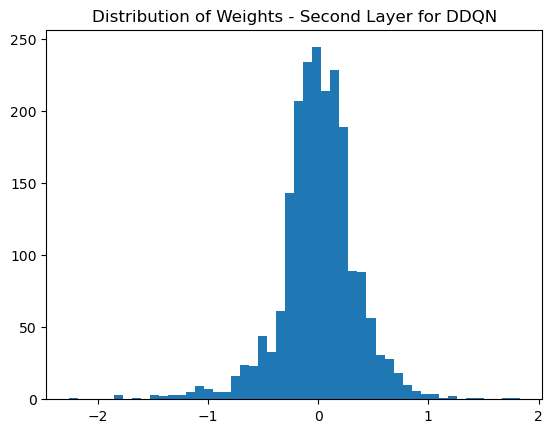

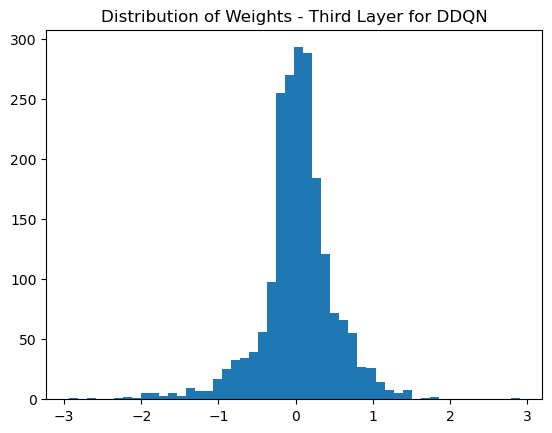

In [ ]:
weights, biases = agent.policy_model.layers[0].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - First Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_first_layer_DDQN.png")
plt.show()
# save the image

# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[1].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Second Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_second_layer_DDQN.png")
plt.show()
# save the image


# Assuming the model has 3 layers
weights, biases = agent.policy_model.layers[2].get_weights()
plt.hist(weights.reshape(-1), bins=50)
plt.title("Distribution of Weights - Third Layer for DDQN")
plt.savefig("../images/training_images/weights_distribution_third_layer_DDQN.png")
plt.show()
# save the image

In [ ]:
# save model
agent.policy_model.save('../models/DDQN_RCmaze_v3.h5')

/home/lucas/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


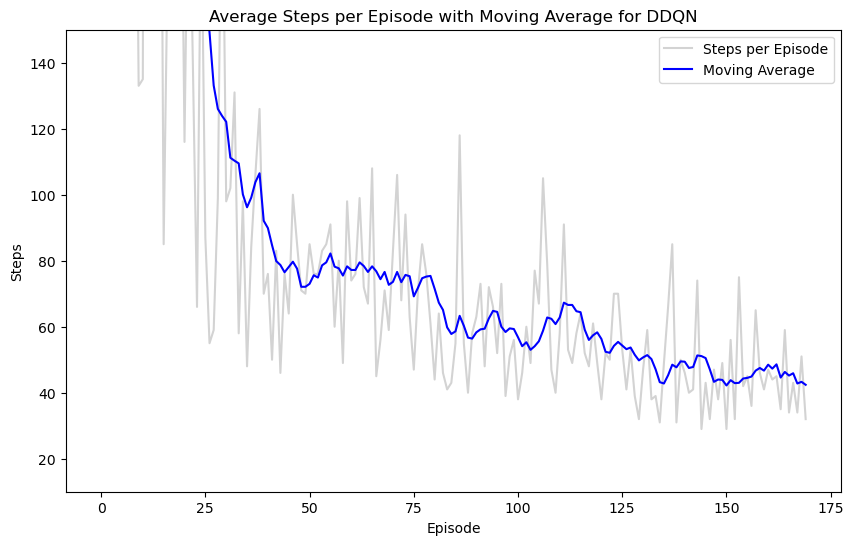

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate moving average
window_size = 10
moving_avg = np.convolve(step_history, np.ones(window_size) / window_size, mode="valid")

low_point = np.argmin(moving_avg)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_history, label="Steps per Episode", color="lightgray")
plt.plot(
    range(window_size - 1, len(step_history)),
    moving_avg,
    label="Moving Average",
    color="blue",
)
# Highlight the lowest point
plt.scatter(low_point, moving_avg[low_point], color="red", label="Lowest Point")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.ylim(10, 150)
plt.title("Average Steps per Episode with Moving Average for DDQN")
plt.legend()
plt.savefig("../images/training_images/steps_per_episode_with_moving_avg_DDQN.png")
plt.show()

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1 -1 -1 -1 -1 -1  0 -1]
 [-1  0 -1  0 -1 -1  0  0  0  0  0 -1]
 [-1  0  0  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  0 -1  0  0  0  0 -1  0 -1 -1 -1]
 [-1  0 -1 -1  0 -1  0  0  0  0  0 -1]
 [-1  0 -1  0  0 -1 -1 -1 -1 -1  0 -1]
 [-1  0  0  0 -1 -1  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


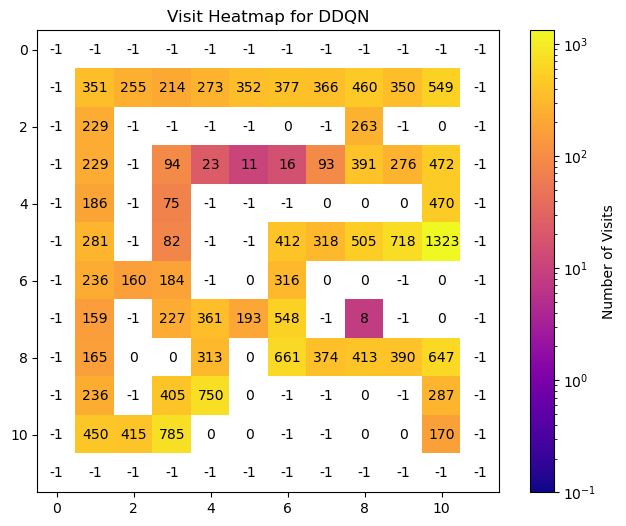

In [ ]:
# Assuming maze_size_x and maze_size_y are the dimensions of your maze
# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)

visit_counts[env.maze == 1] = -1
print(visit_counts)


for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm


def plot_visit_heatmap(visit_counts, title="Visit Heatmap"):
    # Transpose visit_counts to match the expected orientation
    visit_counts_transposed = visit_counts.T  # Transpose the matrix

    # Filter out the wall cells by setting their count to NaN for visualization
    filtered_counts = np.where(
        visit_counts_transposed == -1, np.nan, visit_counts_transposed
    )

    # Define a continuous colormap (you can choose any colormap you like)
    cmap = plt.cm.plasma
    cmap.set_bad("white")  # Use gray for NaN (walls)
    plt.figure(figsize=(8, 6))
    # Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
    plt.imshow(
        filtered_counts,
        cmap=cmap,
        norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
        interpolation="nearest",
    )
    # add the nr of visits to the cells
    for i in range(visit_counts_transposed.shape[0]):
        for j in range(visit_counts_transposed.shape[1]):
            if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
                plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

    plt.colorbar(label="Number of Visits")
    plt.title(title)
    plt.savefig("../images/training_images/visit_heatmap_DDQN.png")
    plt.show()
    # save the image


plot_visit_heatmap(visit_counts, title="Visit Heatmap for DDQN")

[742, 1210, 335, 1383, 472, 181, 1423, 342, 273, 133, 135, 633, 190, 427, 302, 85, 175, 220, 170, 235, 116, 211, 140, 66, 192, 87, 55, 59, 99, 214, 98, 102, 131, 58, 98, 48, 84, 106, 126, 70, 76, 50, 83, 46, 76, 64, 100, 85, 71, 70, 85, 76, 76, 83, 85, 91, 60, 80, 49, 98, 74, 76, 99, 72, 67, 108, 45, 56, 71, 59, 83, 106, 68, 94, 63, 47, 71, 85, 76, 61, 44, 64, 46, 41, 43, 55, 118, 55, 40, 58, 63, 73, 48, 72, 66, 52, 73, 39, 51, 56, 38, 46, 60, 49, 77, 67, 105, 79, 47, 40, 58, 91, 53, 49, 58, 64, 52, 48, 61, 49, 38, 52, 50, 70, 70, 53, 41, 53, 39, 32, 47, 59, 38, 39, 31, 49, 66, 85, 31, 50, 46, 40, 41, 74, 29, 43, 32, 47, 38, 49, 29, 56, 32, 75, 42, 45, 36, 65, 46, 41, 47, 44, 45, 35, 59, 34, 43, 34, 51, 32]


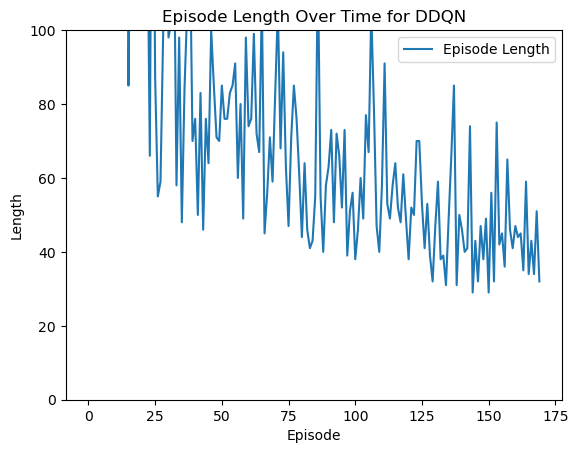

In [ ]:
def plot_episode_lengths(episode_lengths, title="Episode Length Over Time"):
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title(title)
    plt.legend()
    # y limit to avoid showing outliers
    plt.ylim(0, 100)
    plt.savefig("../images/training_images/episode_length_DDQN.png")
    plt.show()
    # save the image

print(step_history)

plot_episode_lengths(step_history, title="Episode Length Over Time for DDQN")

### test

In [ ]:
# try it out
# load model
env = RCMazeEnv()
state = env.reset()

REPLAY_MEMORY_CAPACITY = 2000000
POSSIBLE_ACTIONS = env.possible_actions

# create DQN agent
test_agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, input_shape=state.shape, output_shape=len(POSSIBLE_ACTIONS))

test_agent.policy_model = load_model('../models/DDQN_RCmaze_v3.h5')


done = False

rewards = []
solution_path = []
test_steps = 0

while not done:
    env.render(delay=100, framerate=10)
    qValues = test_agent.policy_network_predict(np.array([state]))
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    test_steps += 1
    print(env.car_position)
    solution_path.append(env.car_position)
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break
env.close()
print(sum(rewards))
print('steps: ', test_steps)
env.close_pygame()

2024-04-09 19:17:38.473177: W tensorflow/c/c_api.cc:305] Operation '{name:'total_19/Assign' id:5524 op device:{requested: '', assigned: ''} def:{{{node total_19/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_19, total_19/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-04-09 19:17:38.670049: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_64_1/kernel/Assign' id:5760 op device:{requested: '', assigned: ''} def:{{{node dense_64_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_64_1/kernel, dense_64_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an er

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 6)
(2, 6)
(3, 6)
(3, 6)
(3, 7)
(3, 7)
(4, 7)
(5, 7)
(6, 7)
(6, 7)
(6, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
(10, 8)
(10, 9)
(10, 10)
done in  25 steps
1253.5006973297018
steps:  25


In [ ]:
test_agent.policy_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 32)                224       
                                                                 
 dense_65 (Dense)            (None, 64)                2112      
                                                                 
 dense_66 (Dense)            (None, 32)                2080      
                                                                 
 dense_67 (Dense)            (None, 3)                 99        
                                                                 
Total params: 4515 (17.64 KB)
Trainable params: 4515 (17.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# test_agent.policy_model.save('./main_web_app/models/DDQN_RCmaze_v2.h5')# 

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 6), (2, 6), (3, 6), (3, 6), (3, 7), (3, 7), (4, 7), (5, 7), (6, 7), (6, 7), (6, 8), (6, 8), (7, 8), (8, 8), (9, 8), (10, 8), (10, 8), (10, 9), (10, 10)]


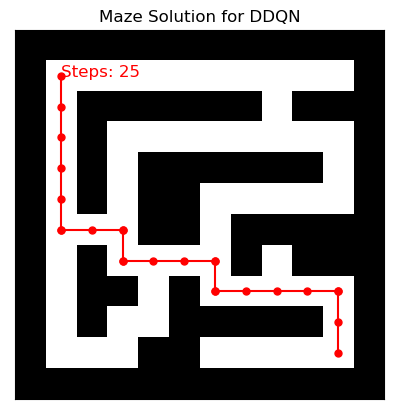

In [ ]:
def plot_maze_solution(maze, path, title="Maze Solution"):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)  # Assuming path is a list of (x, y) tuples
    plt.plot(
        x, y, marker="o", color="r", markersize=5
    ) 
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title(title)
    # show nr of steps
    plt.text(1, 1, f"Steps: {len(path)}", color="red", fontsize=12)
    plt.savefig("../images/training_images/maze_solution_DDQN.png")
    plt.show()
    # save the image


# Example usage
# get the path
path = solution_path
print(path)
plot_maze_solution(env.maze, path, title="Maze Solution for DDQN")

# PPO

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError as mse


class PPOAgent:
    def __init__(self, env, action_dim):
        self.env = env
        self.clip_epsilon = 0.2
        self.optimizer = Adam(learning_rate=0.001)
    
        self.action_dim = action_dim
        self.policy_network = self.build_policy_network()
        self.value_network = self.build_value_network()

    def build_policy_network(self):
    # Create a policy network appropriate for your custom environment
        policy_network = Sequential([
            Input(shape=(6,)),  # Adjust the input shape to (None, 6)
            Dense(32, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(32, activation='tanh'),
            Dense(self.action_dim, activation='softmax')
        ])
        return policy_network

    def build_value_network(self):
        # Create a value network appropriate for your custom environment
        value_network = Sequential([
            Input(shape=(6,)),  # Adjust the input shape to (None, 6)
            Dense(32, activation='tanh'),
            Dense(64, activation='tanh'),
            Dense(32, activation='tanh'),
            Dense(1, activation='linear')
        ])
        return value_network

    def process_observation(self, observation):
        """Flatten observation array and check its validity."""
        flattened_observation = np.hstack(observation)
        if flattened_observation.shape[0] != 6:
            raise ValueError("Invalid observation shape.")
        return flattened_observation

    def compute_discounted_rewards(self, rewards, gamma=0.99):
        """Compute discounted rewards for the episode."""
        discounted_rewards = np.zeros_like(rewards)
        R = 0
        for i in reversed(range(len(rewards))):
            R = rewards[i] + gamma * R
            discounted_rewards[i] = R
        return discounted_rewards

    def compute_advantages(self, discounted_rewards, observations):
        """Compute advantages based on discounted rewards and observations."""
        baseline = np.mean(discounted_rewards)
        advantages = discounted_rewards - baseline
        return advantages

    def compute_loss(self, observations, actions, advantages, old_probabilities):
        """Compute the PPO loss."""
        new_probabilities = self.policy_network(observations)
        action_masks = tf.one_hot(actions, self.action_dim, dtype=tf.float32)
        new_action_probabilities = tf.reduce_sum(action_masks * new_probabilities, axis=1)
        old_action_probabilities = tf.reduce_sum(action_masks * old_probabilities, axis=1)

        ratio = new_action_probabilities / (old_action_probabilities + 1e-10)
        clipped_ratio = tf.clip_by_value(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon)
        surrogate_objective = tf.minimum(ratio * advantages, clipped_ratio * advantages)
        loss = -tf.reduce_mean(surrogate_objective)
        return loss

    
    # def train_step(self, observations, actions, advantages, old_probabilities):
    #     """Train the network with one step of samples."""
    #     with tf.GradientTape() as tape:
    #         loss = self.compute_loss(observations, actions, advantages, old_probabilities)
    #     grads = tape.gradient(loss, self.policy_network.trainable_variables)
    #     self.optimizer.apply_gradients(zip(grads, self.policy_network.trainable_variables))
    #     return loss.numpy()

    def train_step(self, observations, actions, advantages, old_probabilities):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(observations, actions, advantages, old_probabilities)
        grads = tape.gradient(loss, self.policy_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy_network.trainable_variables))
        return K.eval(loss)  # Evaluate the tensor explicitly


    def train_episode(self,episode, max_steps):
        """Run one episode of training, collecting necessary data and updating the network."""
        observations, actions, rewards, probabilities = [], [], [], []
        total_reward = 0
        observation = self.env.reset()
        done = False

        path_history = []
        while not done:

            flattened_observation = self.process_observation(observation)
            action_probabilities = self.policy_network.predict(np.expand_dims(flattened_observation, axis=0))
            # action_probabilities = self.policy_network(np.expand_dims(flattened_observation, axis=0), training=False)

            action = np.random.choice(self.action_dim, p=action_probabilities.ravel())
            
            # render the environment
            # self.env.render(framerate=720, delay=0)
            observation, reward, done = self.env.step(action)
            total_reward += reward
            observations.append(flattened_observation)
            path_history.append((episode, self.env.car_position))
            if done:
                reward += 10000
                total_reward += 10000

            actions.append(action)
            rewards.append(reward)
            probabilities.append(action_probabilities.ravel())

        discounted_rewards = self.compute_discounted_rewards(rewards)
        advantages = self.compute_advantages(discounted_rewards, observations)

        loss = self.train_step(np.vstack(observations), np.array(actions), advantages, np.vstack(probabilities))
        return total_reward, loss, path_history

    def plot_and_save_results(self, reward_history, loss_history,episode_path_history):
        # Reward history plot
        plt.plot(reward_history)
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title("Reward History for PPO")
        plt.savefig('../images/training_images/reward_history_PPO.png')
        plt.show()

        # check -
        self.plot_visit_heatmap(episode_path_history, title="Visit Heatmap for PPO")

        # print reward distribution
        self.plot_reward_distribution(reward_history, title="Reward Distribution for PPO")

        try:
            self.plot_move_avg_reward(reward_history)
        except:
            pass

        try:
            plt.figure()
            plt.plot(loss_history)
            plt.title("Loss over Episodes for PPO")
            plt.xlabel("Episode")
            plt.ylabel("Loss")
            plt.savefig("../images/training_images/loss_history.png")
            plt.show()
        except:
            pass

    def plot_move_avg_reward(self, reward_history, window_size=10):
                # moving average
        window_size = 10
        moving_avg = np.convolve(reward_history, np.ones(window_size) / window_size, mode="valid")

        low_point = np.argmin(moving_avg)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(reward_history, label="Reward per Episode", color="lightgray")
        plt.plot( range(window_size - 1, len(reward_history)), moving_avg, label="Moving Average", color="blue")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Average Reward per Episode with Moving Average for PPO")
        plt.legend()
        plt.savefig("../images/training_images/reward_per_episode_with_moving_avg_PPO.png")
        plt.show()

    def plot_reward_distribution(self, rewards, title="Reward Distribution"):
        plt.hist(rewards, bins=30, alpha=0.7, color="blue")
        plt.xlabel("Reward")
        plt.ylabel("Frequency")
        plt.title(title)
        plt.savefig("../images/training_images/reward_distribution_PPO.png")
        plt.show()
        

    def plot_mse_history(self, mse_history):
        plt.plot(mse_history)
        plt.xlabel('Episode')
        plt.ylabel('loss')
        plt.title("loss over time for PPO")
        plt.savefig("../images/training_images/mse_history_PPO.png")
        plt.show()

    def plot_visit_heatmap(self, episode_path_history, title="Visit Heatmap for PPO"):

        from math import nan
        import matplotlib.pyplot as plt
        import numpy as np
        from matplotlib.colors import ListedColormap, LogNorm

        # convert to dictionary
        episode_path_dict = {}
        for episode, position in episode_path_history:
            if episode in episode_path_dict:
                episode_path_dict[episode].append(position)
            else:
                episode_path_dict[episode] = [position]

        maze = self.env.maze

        visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)



        for episode, path in episode_path_dict.items():
            for position in path:
                visit_counts[position] += 1

        # visit_counts[env.maze == 1] = -1
        print(visit_counts)

        # Transpose visit_counts to match the expected orientation
        visit_counts_transposed = visit_counts.T  # Transpose the matrix

        # Filter out the wall cells by setting their count to NaN for visualization
        # filtered_counts = np.where(
        #     visit_counts_transposed == -1, np.nan, visit_counts_transposed
        # )
        filtered_counts = visit_counts_transposed
        # set the walls to -1
        filtered_counts[env.maze == 1] = -1
        

        # Define a continuous colormap (you can choose any colormap you like)
        cmap = plt.cm.plasma
        cmap.set_bad("white")  # Use gray for NaN (walls)
        plt.figure(figsize=(12, 8))
        # Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
        plt.imshow(
            filtered_counts,
            cmap=cmap,
            norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
            interpolation="nearest",
        )
        # add the nr of visits to the cells
        for i in range(visit_counts_transposed.shape[0]):
            for j in range(visit_counts_transposed.shape[1]):
                if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
                    plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

        plt.colorbar(label="Number of Visits")
        plt.title(title)
        plt.savefig("../images/training_images/visit_heatmap_PPO.png")
        plt.show()
            # save the image


    def train(self, num_episodes, max_steps_per_episode):
        """Main training loop."""
        reward_history = []
        loss_history = []
        episode_path_history = []
        for episode in range(num_episodes):
            self.env.reset()
            total_reward, loss, path_history = self.train_episode(episode ,max_steps_per_episode)
            reward_history.append(total_reward)
            loss_history.append(loss)
            print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Loss: {loss}")
            for path in path_history:
                episode_path_history.append(path)
        
        print('reward_history:',reward_history)
        print('loss_history:',loss_history)
        print('episode_path_history:',episode_path_history)
        self.plot_and_save_results(reward_history, loss_history, episode_path_history)


In [5]:
def state_to_tuple( state):
      
      #((0, 0), 'N', {'front': 1, 'left': 0, 'right': 0})
      # if like this convert to ((0, 0), 'N', (1, 0, 0))
      if not isinstance(state[2], dict):
         # print(state)
         # print(state[2])
         #take state[2] and make it from this (1, 0, 0) to this {'front': 1, 'left': 0, 'right': 0}
         newState = {'front': state[2][0], 'left': state[2][1], 'right': state[2][2]}
         # print(newState)
         #create a new state with the [2] being the new dictionary
         state = (state[0], state[1], newState)
         
      # Convert the state dictionary to a hashable tuple
      # Adjust this based on the specific format of your state
      position, orientation, sensor_readings = state
      sensor_readings_tuple = tuple(sensor_readings.values())
      return (position, orientation, sensor_readings_tuple)

In [9]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

2024-05-10 12:38:51.292908: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_28/kernel/Assign' id:76952 op device:{requested: '', assigned: ''} def:{{{node dense_28/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_28/kernel, dense_28/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Episode 1/175, Total Reward: -14067.560551924806, Loss: 9.436958862352185e-06
Episode 2/175, Total Reward: -6749.417993950658, Loss: -3.331894913571887e-05
Episode 3/175, Total Reward: -5291.4785630100905, Loss: -1.3014635442232247e-05
Episode 4/175, Total Reward: 5699.549969575406, Loss: 9.191176104650367e-06
Episode 5/175, Total Reward: -5824.274451364152, Loss: -7.217090114863822e-06
Episode 6/175, Total Reward: -6587.586732784832, Loss: 1.2498667274485342e-06
Episode 7/175, Total Reward: -1361.7774610639553, Loss: -2.703287282201927e-05
Episode 8/175, Total Reward: -9377.007081154054, Loss: -1.5294381228159182e-05
Episode 9/175, Total Reward: 2171.8520022178163, Loss: 1.4722048035764601e-05
Episode 10/175, Total Reward: -12047.73028796511, Loss: -1.8382352209300734e-05
Episode 11/175, Total Reward: -8244.533583012606, Loss: -6.260016107262345e-06
Episode 12/175, Total Reward: 5527.152170094182, Loss: 1.0629251846694387e-05
Episode 13/175, Total Reward: -2553.192678669764, Loss: 8.4

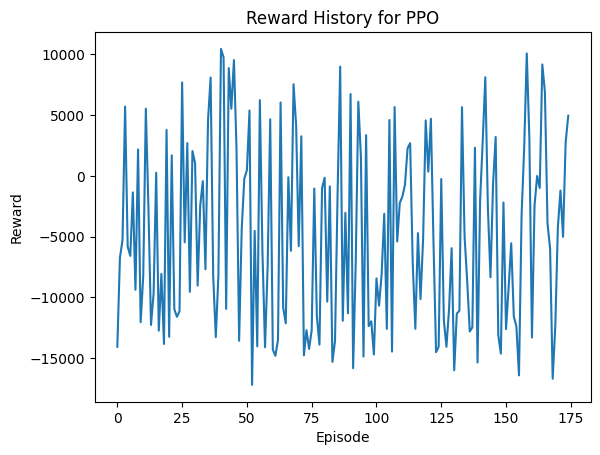

[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0 17337  9317  8474  8122  7350  6284  7143  6131  7738 16791     0]
 [    0  9538     0     0     0     0  3288     0     0     0 10385     0]
 [    0  7453     0  7747  4628  4114  2914  7518     0 10444 12136     0]
 [    0  6270     0  3607     0     0     0  4025  3545  7859     0     0]
 [    0  5664     0  2911     0     0     0  4696     0     0     0     0]
 [    0  5682     0  2759     0  9732  5098  5066  7414     0     0     0]
 [    0  6333     0  3382     0  5723     0     0  4411     0     0     0]
 [    0  4180  1480  3456     0  4974     0  2282  2084     0     0     0]
 [    0  9250     0  4616     0  6050     0     0  1741     0     0     0]
 [    0 31587     0 10035  5044 10937     0     0  1947   721   111     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]]


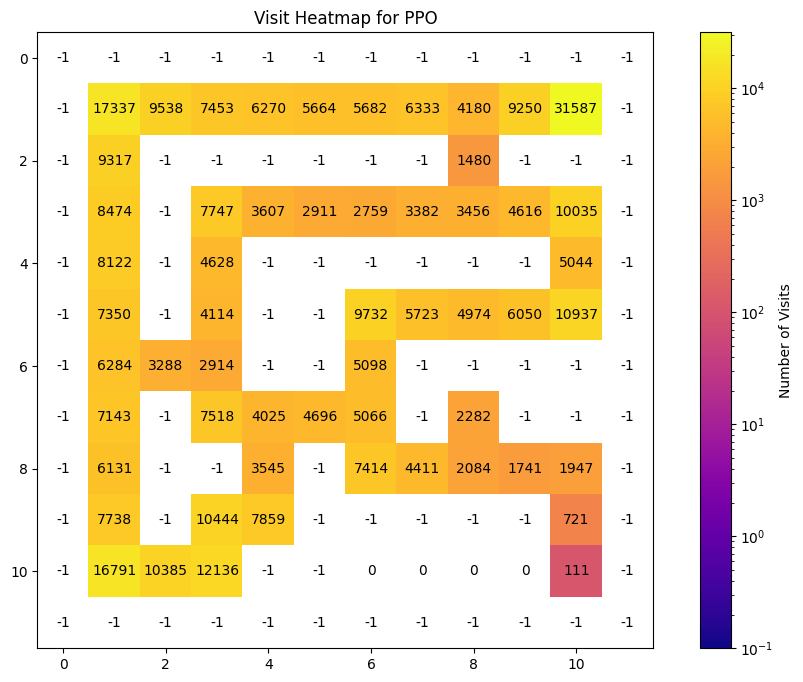

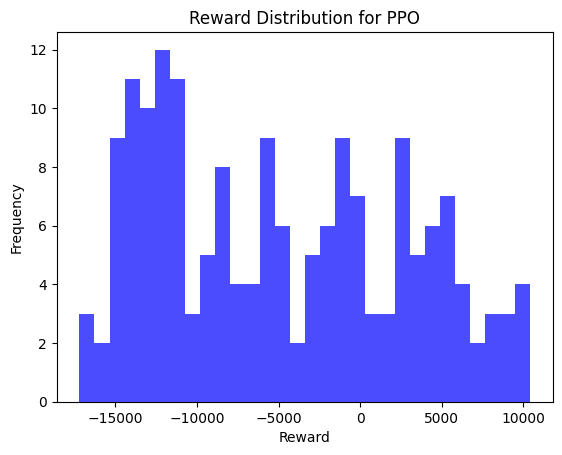

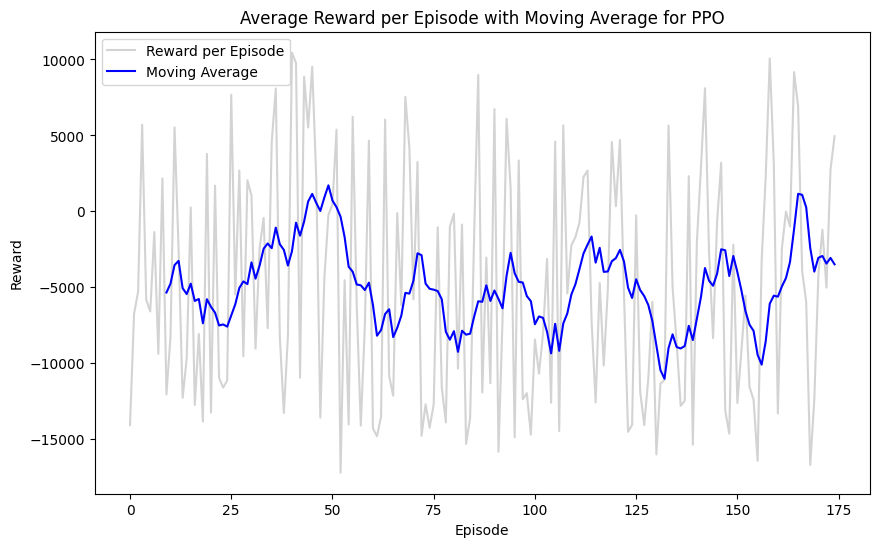

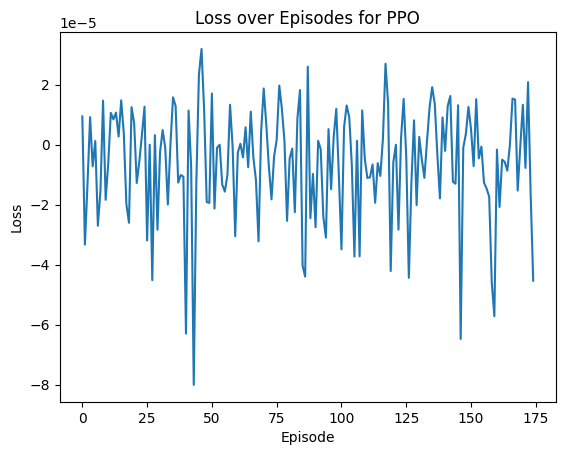

In [11]:
env = RCMazeEnv()  # Create your custom environment

observation_dim = env.reset().shape[0]  # Adjust this based on your custom environment's state space
action_dim = 3  # Adjust this based on your custom environment's action space
ppo_agent = PPOAgent(env, action_dim=action_dim)

ppo_agent.train(num_episodes=175, max_steps_per_episode=3000)



# q-agent

In [4]:
# class QAgent:
#     def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, possible_actions=3, min_epsilon=0.01, epsilon_decay=0.99):
#         self.q_table = {}
#         self.alpha = alpha
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.possible_actions = possible_actions
#         self.min_epsilon = min_epsilon
#         self.epsilon_decay = epsilon_decay

#     def get_q_value(self, state, action):
#         """Retrieve Q value for a given state-action pair, defaults to 0."""
#         state = tuple(state)  # Convert state to tuple for hashing
#         return self.q_table.get((state, action), 0)

#     # def choose_action(self, state, test=False):
#     #     """Choose an action based on epsilon-greedy policy."""
#     #     state = tuple(state)  # Convert state to tuple for consistent hashing
#     #     if random.random() < self.epsilon:
#     #         return random.randint(0, self.possible_actions - 1)
#     #     else:
#     #         q_values = [self.get_q_value(state, action) for action in range(self.possible_actions)]
#     #         max_q = max(q_values)
#     #         return random.choice([action for action, q in enumerate(q_values) if q == max_q])

#     def choose_action(self, state, test=False):
#         """Choose an action based on epsilon-greedy policy or optimal policy if testing."""
#         state = tuple(state)  # Convert state to tuple for consistent hashing
#         if test:
#             return np.argmax([self.get_q_value(state, action) for action in range(self.possible_actions)])
#         if not test and random.random() < self.epsilon:
#             return random.randint(0, self.possible_actions - 1)
#         else:
#             q_values = [self.get_q_value(state, action) for action in range(self.possible_actions)]
#             max_q = max(q_values)
#             return random.choice([action for action, q in enumerate(q_values) if q == max_q])


#     def update_q_value(self, state, action, reward, next_state):
#         """Update Q value for a state-action pair using the learning rule."""
#         state = tuple(state)  # Convert state to tuple for hashing
#         next_state = tuple(next_state)
#         max_q_next = max(self.get_q_value(next_state, a) for a in range(self.possible_actions))
#         current_q = self.get_q_value(state, action)
#         new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
#         self.q_table[(state, action)] = new_q

#     def train(self, environment, num_episodes):
#         reward_history = []
#         episode_path_history = []
#         step_history = []
#         epselon_history = []
#         for _ in range(num_episodes):
#             state = environment.reset()
#             state = tuple(state)
#             done = False
#             total_reward = 0
#             step_counter = 0
#             while not done:
#                 action = self.choose_action(state)
#                 next_state, reward, done = environment.step(action)
#                 self.update_q_value(state, action, reward, next_state)
#                 total_reward += reward
#                 state = next_state
#                 step_counter += 1
#                 episode_path_history.append((_, environment.car_position))
#             # Add the total reward for this episode to the history
#             reward_history.append(total_reward)
#             step_history.append(step_counter)
#             epselon_history.append(self.epsilon)
#             # Decay epsilon, but not below the minimum value
#             self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

#             # Print episode summary
#             print("Episode finished after {} timesteps".format(environment.steps))
#             print(
#                 "Total reward: {}, Epsilon: {:.3f}".format(total_reward, self.epsilon)
#             )

#         return reward_history, episode_path_history, step_history, epselon_history

#     def test(self, environment):
#         state = environment.reset()
#         state = tuple(state)  # Convert initial state to a tuple for consistency
#         done = False
#         total_reward = 0
#         solution_path = []
#         while not done:
#             environment.render()
#             action = self.choose_action(state, test=True)
#             next_state, reward, done = environment.step(action)
#             next_state = tuple(next_state)  # Convert next_state to a tuple
#             state = next_state  # Move to the next state
#             total_reward += reward  # Accumulate total reward
#             solution_path.append(environment.car_position)

#         print(f"Test Total Reward: {total_reward}")
#         return total_reward, solution_path


import numpy as np
import random

class QAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, possible_actions=3, min_epsilon=0.01, epsilon_decay=0.99):
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.possible_actions = possible_actions
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay

    def get_q_value(self, state, action):
        """Retrieve Q value for a given state-action pair, defaults to a small random value."""
        state = tuple(state)  # Convert state to tuple for hashing
        return self.q_table.get((state, action), random.uniform(-0.01, 0))

    def choose_action(self, state, test=False):
        """Choose an action based on epsilon-greedy policy or optimal policy if testing."""
        state = tuple(state)  # Convert state to tuple for consistent hashing
        if test:
            return np.argmax([self.get_q_value(state, action) for action in range(self.possible_actions)])
        if not test and random.random() < self.epsilon:
            return random.randint(0, self.possible_actions - 1)
        else:
            q_values = [self.get_q_value(state, action) for action in range(self.possible_actions)]
            max_q = max(q_values)
            # In case there are several max Q-values, randomly choose one of them
            return random.choice([action for action, q in enumerate(q_values) if q == max_q])

    def update_q_value(self, state, action, reward, next_state):
        """Update Q value for a state-action pair using the learning rule."""
        state = tuple(state)
        next_state = tuple(next_state)
        max_q_next = max(self.get_q_value(next_state, a) for a in range(self.possible_actions))
        current_q = self.get_q_value(state, action)
        new_q = current_q + self.alpha * (reward + self.gamma * max_q_next - current_q)
        self.q_table[(state, action)] = new_q

    def train(self, environment, num_episodes):
        reward_history = []
        episode_path_history = []
        step_history = []
        epsilon_history = []
        for episode in range(num_episodes):
            state = environment.reset()
            state = tuple(state)
            done = False
            total_reward = 0
            step_counter = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = environment.step(action)
                self.update_q_value(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                step_counter += 1
                episode_path_history.append((episode, environment.car_position))
            reward_history.append(total_reward)
            step_history.append(step_counter)
            epsilon_history.append(self.epsilon)
            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

            print(f"Episode {episode} finished after {step_counter} timesteps, Total reward: {total_reward}, Epsilon: {self.epsilon:.3f}")

        return reward_history, episode_path_history, step_history, epsilon_history

    def test(self, environment):
        state = environment.reset()
        state = tuple(state)
        done = False
        total_reward = 0
        solution_path = []
        while not done:
            environment.render()
            action = self.choose_action(state, test=True)
            next_state, reward, done = environment.step(action)
            next_state = tuple(next_state)
            state = next_state
            total_reward += reward
            solution_path.append(environment.car_position)

        print(f"Test Total Reward: {total_reward}")
        return total_reward, solution_path


## training

In [5]:
EPSILON = 0.99  # High initial exploration
ALPHA = 0.05    # Increase learning rate for faster adaptation
GAMMA = 0.9     # Focus more on future rewards
DECAY_RATE = 0.9998  # Keep as is, standard rate
MINEPSILON = 0.05  # Allow for more exploitation as learning progresses




env = RCMazeEnv()
agent = QAgent(
    alpha=ALPHA,
    gamma=GAMMA,
    epsilon=EPSILON,
    min_epsilon=MINEPSILON,
    epsilon_decay=DECAY_RATE,
)
# env.init_pygame()
reward_history , episode_path_history, step_history, epselon_history = agent.train(env, 5000)
env.close_pygame()

Episode 0 finished after 599 timesteps, Total reward: -2677.0610289391334, Epsilon: 0.990
Episode 1 finished after 2363 timesteps, Total reward: -13425.737321085115, Epsilon: 0.990
Episode 2 finished after 1297 timesteps, Total reward: -6946.365555761435, Epsilon: 0.989
Episode 3 finished after 420 timesteps, Total reward: -1525.866070346358, Epsilon: 0.989
Episode 4 finished after 3001 timesteps, Total reward: -22660.057313681056, Epsilon: 0.989
Episode 5 finished after 3001 timesteps, Total reward: -22718.450479772247, Epsilon: 0.989
Episode 6 finished after 1452 timesteps, Total reward: -9681.597504617475, Epsilon: 0.989
Episode 7 finished after 1055 timesteps, Total reward: -6467.0315860259625, Epsilon: 0.988
Episode 8 finished after 3001 timesteps, Total reward: -23826.159019510014, Epsilon: 0.988
Episode 9 finished after 3001 timesteps, Total reward: -22000.814042242164, Epsilon: 0.988
Episode 10 finished after 3001 timesteps, Total reward: -24692.595279161127, Epsilon: 0.988
Epi

## results

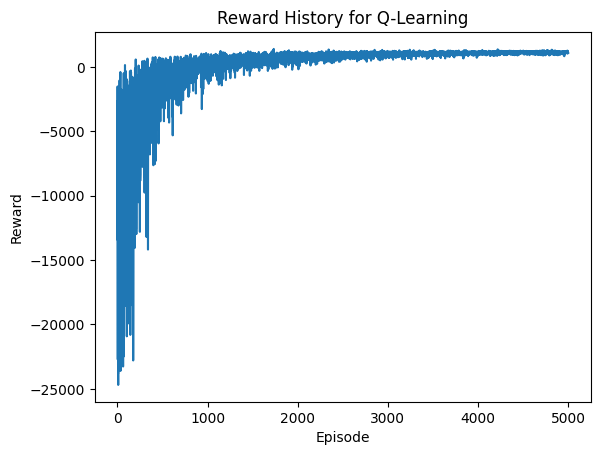

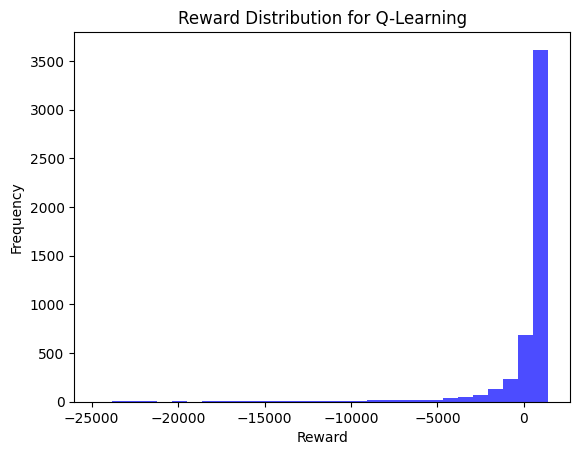

In [6]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for Q-Learning")
plt.savefig('../images/training_images/reward_history_Qlearning.png')
plt.show()
# save the image

def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.savefig("../images/training_images/reward_distribution_Q-agent.png")
    plt.show()
    # save the image


plot_reward_distribution(reward_history, title="Reward Distribution for Q-Learning")



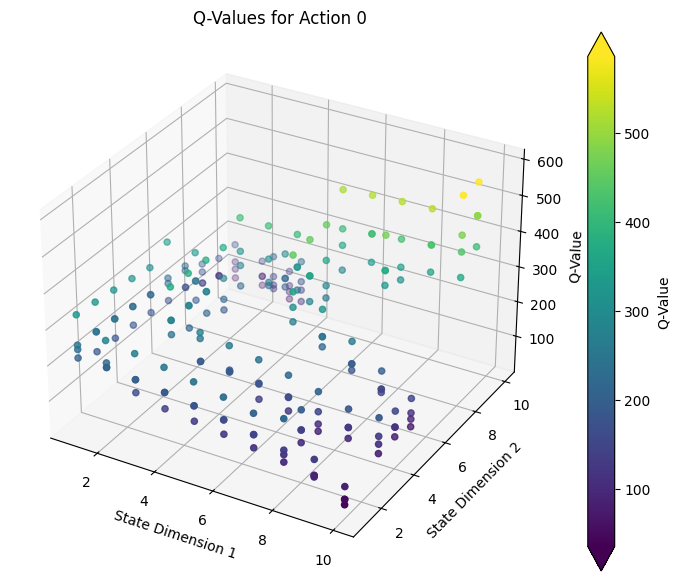

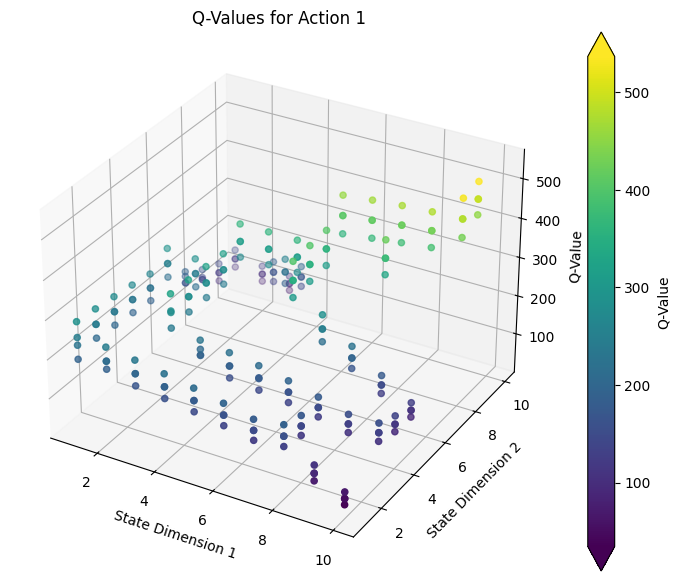

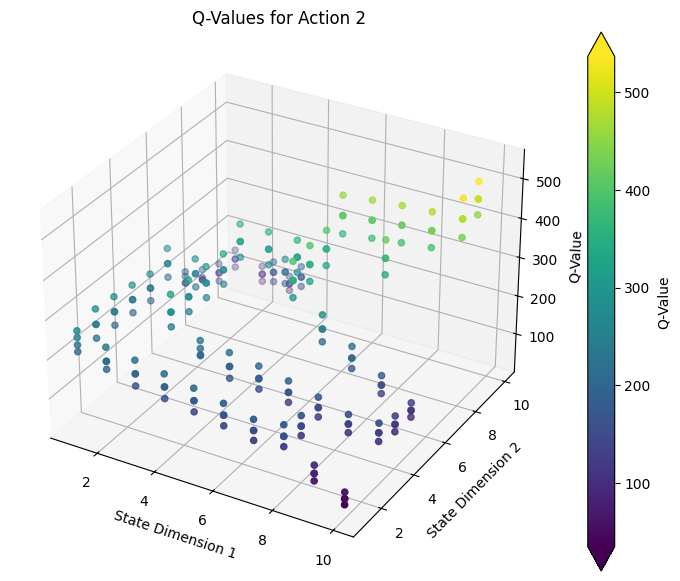

In [7]:
def plot_q_table_3d(agent, action_index):
    x = []
    y = []
    z = []

    # Loop through the Q-table and collect x, y, and z only for the given action index
    for (state, action), value in agent.q_table.items():
        if action == action_index:
            x.append(state[0])
            y.append(state[1])
            z.append(value)

    # Convert lists to numpy arrays for plotting
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

    # Label the axes and set a title
    ax.set_xlabel('State Dimension 1')
    ax.set_ylabel('State Dimension 2')
    ax.set_zlabel('Q-Value')
    ax.set_title(f'Q-Values for Action {action_index}')

    # Adding a color bar to indicate the scale of Q-values
    color_bar = fig.colorbar(scatter, ax=ax, extend='both')
    color_bar.set_label('Q-Value')
    plt.savefig(f"../images/training_images/q_table_3d_Q-agent_{action_index}.png")
    plt.show()

# Example usage
plot_q_table_3d(agent, action_index=0)
plot_q_table_3d(agent, action_index=1)
plot_q_table_3d(agent, action_index=2)


[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0 29763 21724 20469 21099 22005 24148 10797  8950  9842 14365     0]
 [    0 13983     0     0     0     0 15906     0     0     0 10031     0]
 [    0 13904     0  8906  8427 11108 24690 30895     0 15205 15256     0]
 [    0 14475     0  5873     0     0     0 24186 11528 16503     0     0]
 [    0 14525     0  5965     0     0     0 24011     0     0     0     0]
 [    0 15818     0  7958     0 26476 20808 38546 44986     0     0     0]
 [    0 16772     0  9071     0 16692     0     0 27036     0     0     0]
 [    0 18970 12121 17547     0 15739     0 11220 26944     0     0     0]
 [    0 14312     0 14745     0 15931     0     0 27029     0     0     0]
 [    0 15644     0 22912 15746 24382     0     0 36708 16788  4973     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]]


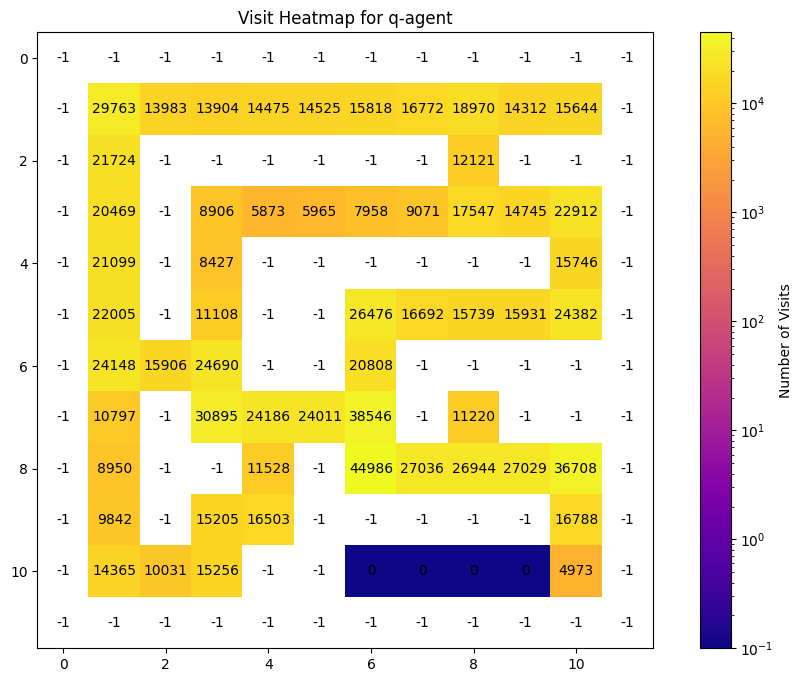

In [8]:

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm

# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)



for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

# visit_counts[env.maze == 1] = -1
print(visit_counts)

# Transpose visit_counts to match the expected orientation
visit_counts_transposed = visit_counts.T  # Transpose the matrix

# Filter out the wall cells by setting their count to NaN for visualization
# filtered_counts = np.where(
#     visit_counts_transposed == -1, np.nan, visit_counts_transposed
# )
filtered_counts = visit_counts_transposed
# set the walls to -1
filtered_counts[env.maze == 1] = -1


# Define a continuous colormap (you can choose any colormap you like)
cmap = plt.cm.plasma
cmap.set_bad("white")  # Use gray for NaN (walls)
plt.figure(figsize=(12, 8))
# Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
plt.imshow(
    filtered_counts,
    cmap=cmap,
    norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
    interpolation="nearest",
)
# add the nr of visits to the cells
for i in range(visit_counts_transposed.shape[0]):
    for j in range(visit_counts_transposed.shape[1]):
        if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
            plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

plt.colorbar(label="Number of Visits")
plt.title("Visit Heatmap for q-agent")
plt.savefig("../images/training_images/visit_heatmap_q-agent.png")
plt.show()
    # save the image

## test

Test Total Reward: 1253.5006973297018


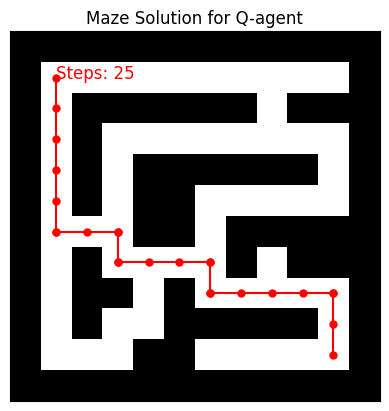

In [10]:
# test
env = RCMazeEnv()


# Example of running the environment
reward, path = agent.test(env)


# env.close_pygame()

# plot the solution

def plot_maze_solution(maze, path, title="Maze Solution"):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)  # Assuming path is a list of (x, y) tuples
    plt.plot(
        x, y, marker="o", color="r", markersize=5
    )  # Plot the path as red circles
    plt.text(1, 1, f"Steps: {len(path)}", color="red", fontsize=12)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title(title)
    plt.savefig("../images/training_images/maze_solution_Q-agent.png")
    plt.show()
    # save the image

plot_maze_solution(env.maze, path, title="Maze Solution for Q-agent")


# dqn

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import random
# import collections
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError

# mse = MeanSquaredError()

mse = tf.keras.losses.MeanSquaredError()

class DQNAgent:
    def __init__(self, replayCapacity, input_shape, output_shape, learning_rate=0.001, discount_factor=0.90):
        self.capacity = replayCapacity
        self.memory = collections.deque(maxlen=self.capacity)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.model = self.buildNetwork()

    def addToReplayMemory(self, step):
        self.memory.append(step)

    def sampleFromReplayMemory(self, batchSize):
        return random.sample(self.memory, batchSize) if len(self.memory) >= batchSize else []

    def buildNetwork(self):
        model = Sequential([
            Input(shape=self.input_shape),
            Dense(32, activation="relu"),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(self.output_shape, activation="linear"),
        ])
        model.compile(loss=mse, optimizer=Adam(learning_rate=self.learning_rate), metrics=["mean_squared_error"])
        return model

    def policy_network_fit(self, batch, batch_size):
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        q_values = self.model.predict(states)
        q_values_next = self.model.predict(next_states)
        
        for i in range(batch_size):
            if dones[i]:
                q_values[i, actions[i]] = rewards[i]
            else:
                q_values[i, actions[i]] = rewards[i] + self.discount_factor * np.max(q_values_next[i])

        return self.model.fit(states, q_values, batch_size=batch_size, verbose=0)

    def policy_network_predict(self, state):
        return self.model.predict(np.array([state]))

# Assume env and RCMazeEnv are defined somewhere
env = RCMazeEnv()
state = env.reset()

REPLAY_MEMORY_CAPACITY = 2000000
POSSIBLE_ACTIONS = env.possible_actions

agent = DQNAgent(replayCapacity=REPLAY_MEMORY_CAPACITY, 
                 input_shape=state.shape, 
                 output_shape=len(POSSIBLE_ACTIONS),
                 learning_rate=0.001, 
                 discount_factor=0.90)

BATCH_SIZE = 128
EPSILON = 0.99
MIN_EPSILON = 0.01
DECAY = 0.99993
EPISODE_AMOUNT = 175
reward_history = []
epsilon_history = []
mse_history = []
episode_path_history = []
step_history = []

for episode in range(EPISODE_AMOUNT):
    state = env.reset()
    episode_reward = 0
    done = False
    step_counter = 0
    while not done:
        if random.random() <= EPSILON:
            action = random.choice(POSSIBLE_ACTIONS)
        else:
            q_values = agent.policy_network_predict(state)
            action = np.argmax(q_values[0])
        
        new_state, reward, done = env.step(action)
        step_counter += 1
        agent.addToReplayMemory((state, action, reward, new_state, done))
        state = new_state
        episode_reward += reward
        episode_path_history.append((episode, env.car_position))

        if len(agent.memory) >= BATCH_SIZE:
            batch = agent.sampleFromReplayMemory(BATCH_SIZE)
            history = agent.policy_network_fit(batch, BATCH_SIZE)
            mse_history.append(history.history['mean_squared_error'])
            EPSILON = max(EPSILON * DECAY, MIN_EPSILON)
    
    reward_history.append(episode_reward)
    epsilon_history.append(EPSILON)
    step_history.append(step_counter)
    print(f'Episode {episode}: Reward = {episode_reward}, Epsilon = {EPSILON}')




/home/lucas/miniconda3/envs/xd/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-10 12:57:16.412777: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/bias/Assign' id:512 op device:{requested: '', assigned: ''} def:{{{node dense_7/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_7/bias, dense_7/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-10 12:57:16.475510: W tensorflow/c/c_api.cc:305] Operation '{name:'loss_1/mul' id:560 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT,

Episode 0: Reward = -10635.112705340602, Epsilon = 0.8723672694262079
Episode 1: Reward = -2238.2329476391405, Epsilon = 0.8379505648835364
Episode 2: Reward = -13042.677337467027, Epsilon = 0.6948059169998598
Episode 3: Reward = -582.9642060154631, Epsilon = 0.6810337400056113
Episode 4: Reward = 829.6924696835424, Epsilon = 0.6754313748502601
Episode 5: Reward = -4233.989563050516, Epsilon = 0.6391822531535875
Episode 6: Reward = 488.16752027015275, Epsilon = 0.6318861453120163
Episode 7: Reward = 555.0636665830473, Epsilon = 0.6258113012644183
Episode 8: Reward = 1039.0694693431628, Epsilon = 0.621968018596174
Episode 9: Reward = 876.316309732447, Epsilon = 0.6182348884594215
Episode 10: Reward = 1041.8730638391069, Epsilon = 0.6155143805116626
Episode 11: Reward = 374.11086402863145, Epsilon = 0.6079775020547825
Episode 12: Reward = -397.3670990731523, Epsilon = 0.5940521244394766
Episode 13: Reward = 879.7819708478944, Epsilon = 0.5903625555090001
Episode 14: Reward = 950.29598528

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 10)
(2, 10)
(3, 10)
(3, 10)
(3, 9)
(3, 9)
(4, 9)
(4, 9)
(4, 8)
(4, 7)
(4, 7)
(5, 7)
(6, 7)
(6, 7)
(6, 8)
(6, 8)
(7, 8)
(8, 8)
(9, 8)
(10, 8)
(10, 8)
(10, 9)
(10, 10)
done in  33 steps
1258.7326524824198
steps:  33


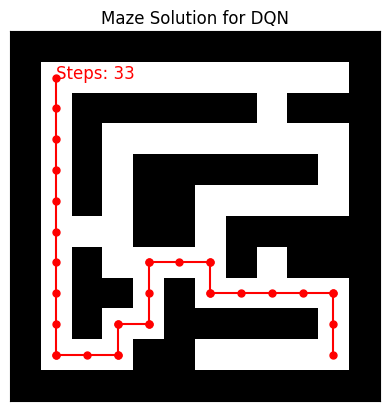

In [20]:
# test out
env = RCMazeEnv()
state = env.reset()

done = False

rewards = []
solution_path = []
test_steps = 0

while not done:
    env.render(delay=100, framerate=10)
    qValues = agent.policy_network_predict(state)
    action = np.argmax(qValues[0])
    state, reward, done = env.step(action)
    rewards.append(reward)
    test_steps += 1
    print(env.car_position)
    solution_path.append(env.car_position)
    env.render()
    if done:
        print('done in ', len(rewards), 'steps')
        break

env.close()

print(sum(rewards))
print('steps: ', test_steps)
env.close_pygame()

# plot the path
def plot_maze_solution(maze, path, title="Maze Solution"):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)  # Assuming path is a list of (x, y) tuples
    plt.plot(
        x, y, marker="o", color="r", markersize=5
    ) 
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title(title)
    # show nr of steps
    plt.text(1, 1, f"Steps: {len(path)}", color="red", fontsize=12)
    plt.savefig("../images/training_images/maze_solution_DQN.png")
    plt.show()
    # save the image

# Example usage
plot_maze_solution(env.maze, solution_path, title="Maze Solution for DQN")

### results

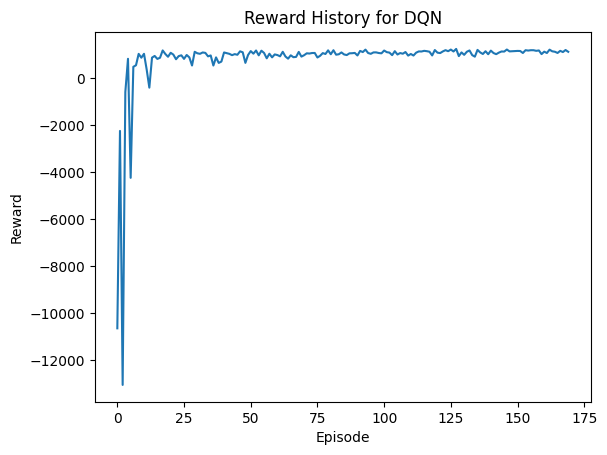

In [21]:
# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for DQN")
plt.savefig('../images/training_images/reward_history_DQN.png')
plt.show()
# save the image

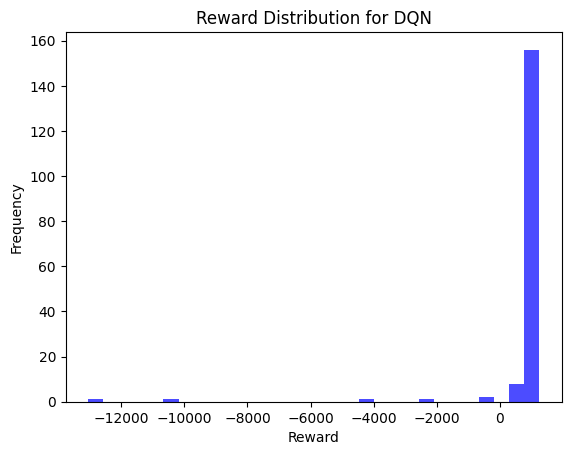

In [22]:
def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.savefig("../images/training_images/reward_distribution_DQN.png")
    plt.show()
    # save the image


# Example usage:
# Assuming `rewards` is a list of total rewards per episode.
# plot_reward_distribution(rewards)
plot_reward_distribution(reward_history, title="Reward Distribution for DQN")

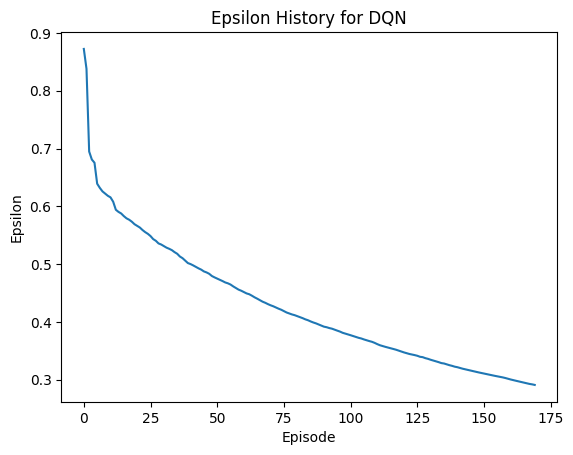

In [23]:
# plot epsilon over time
plt.plot(epsilon_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title("Epsilon History for DQN")
plt.savefig("../images/training_images/epsilon_history_DQN.png")
plt.show()
# save the image

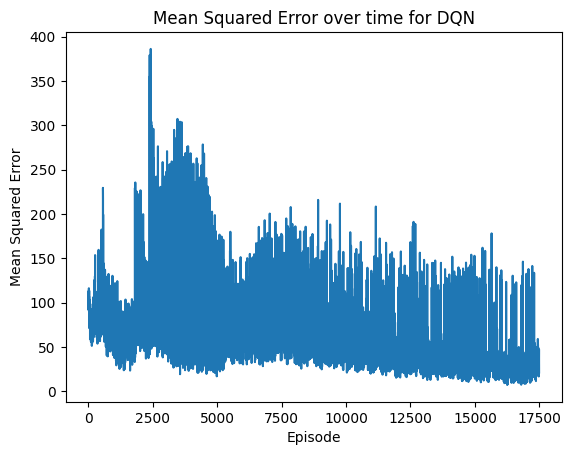

In [24]:
# evalution

# plot mse
plt.plot(mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time for DQN")
plt.savefig("../images/training_images/mse_history_DQN.png")
plt.show()
# save the image

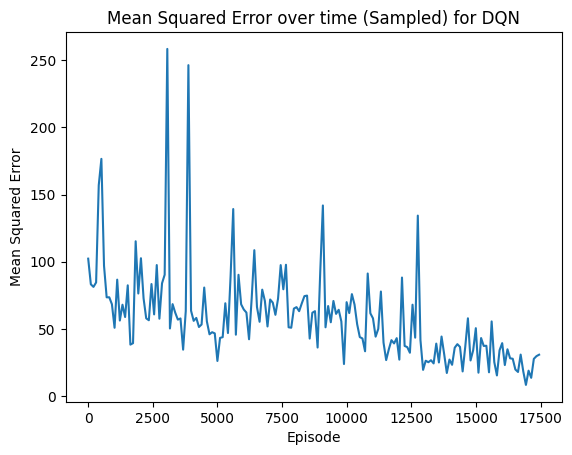

In [25]:
# Assuming mse_history is a flat list with the correct number of elements
EPISODE_AMOUNT = len(mse_history)  # Make sure this reflects the actual number of episodes
desired_samples = 170  # The number of points you want to plot

# Calculate the step size
step = max(EPISODE_AMOUNT // desired_samples, 1)  # Avoid division by zero
sampled_mse_history = mse_history[::step]

# Ensure sampled_episodes has the same number of elements as sampled_mse_history
sampled_episodes = list(range(0, EPISODE_AMOUNT, step))[:len(sampled_mse_history)]

plt.plot(sampled_episodes, sampled_mse_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time (Sampled) for DQN")
plt.savefig("../images/training_images/mse_history_sampled_DQN.png")
plt.show()
# save the image

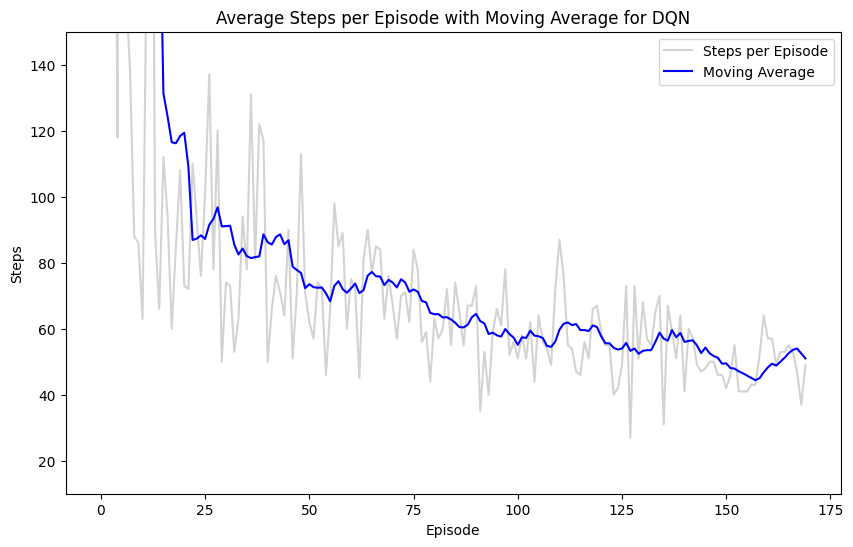

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate moving average
window_size = 10
moving_avg = np.convolve(step_history, np.ones(window_size) / window_size, mode="valid")

low_point = np.argmin(moving_avg)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(step_history, label="Steps per Episode", color="lightgray")
plt.plot(
    range(window_size - 1, len(step_history)),
    moving_avg,
    label="Moving Average",
    color="blue",
)
# Highlight the lowest point
# plt.scatter(low_point, moving_avg[low_point], color="red", label="Lowest Point")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.ylim(10, 150)
plt.title("Average Steps per Episode with Moving Average for DQN")
plt.legend()
plt.savefig("../images/training_images/steps_per_episode_with_moving_avg_DQN.png")
plt.show()

[[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  294  159  150  207  133  197  175  214  183  326    0]
 [   0  234    0    0    0    0   93    0    0    0  280    0]
 [   0  294    0   33   16   10   94  112    0  395  621    0]
 [   0  264    0   37    0    0    0  288  241  584    0    0]
 [   0  267    0   21    0    0    0  257    0    0    0    0]
 [   0  264    0   34    0  581  229  543  762    0    0    0]
 [   0  320    0  121    0  443    0    0  367    0    0    0]
 [   0  466  253  418    0  567    0   25  337    0    0    0]
 [   0  200    0  400    0  723    0    0  411    0    0    0]
 [   0  274    0  610  556 1295    0    0  719  351  170    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0]]


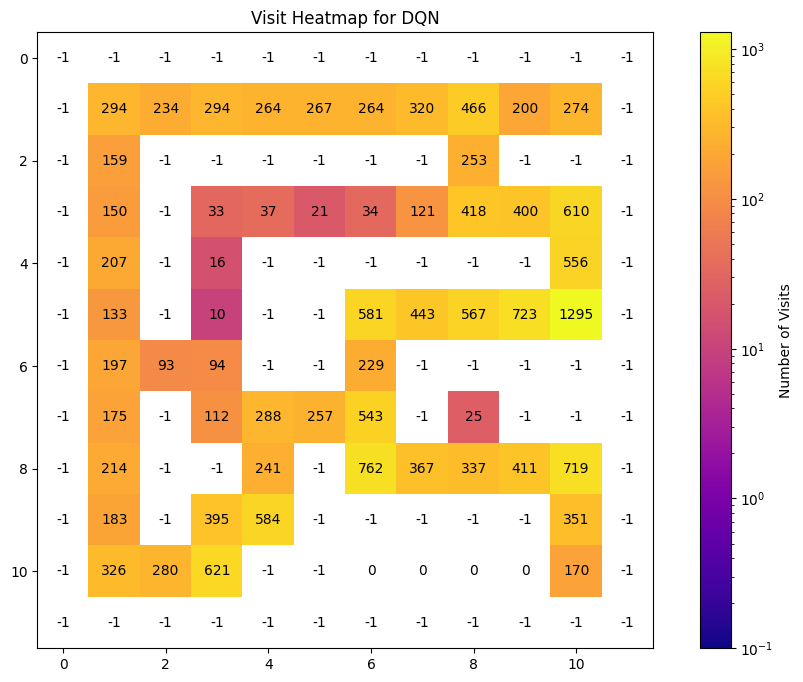

In [31]:

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm

# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)



for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

# visit_counts[env.maze == 1] = -1
print(visit_counts)

# Transpose visit_counts to match the expected orientation
visit_counts_transposed = visit_counts.T  # Transpose the matrix

# Filter out the wall cells by setting their count to NaN for visualization
# filtered_counts = np.where(
#     visit_counts_transposed == -1, np.nan, visit_counts_transposed
# )
filtered_counts = visit_counts_transposed
# set the walls to -1
filtered_counts[env.maze == 1] = -1


# Define a continuous colormap (you can choose any colormap you like)
cmap = plt.cm.plasma
cmap.set_bad("white")  # Use gray for NaN (walls)
plt.figure(figsize=(12, 8))
# Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
plt.imshow(
    filtered_counts,
    cmap=cmap,
    norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
    interpolation="nearest",
)
# add the nr of visits to the cells
for i in range(visit_counts_transposed.shape[0]):
    for j in range(visit_counts_transposed.shape[1]):
        if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
            plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

plt.colorbar(label="Number of Visits")
plt.title("Visit Heatmap for DQN")
plt.savefig("../images/training_images/visit_heatmap_DQN.png")
plt.show()
    # save the image

[1934, 575, 2676, 286, 118, 788, 164, 138, 88, 86, 63, 176, 331, 89, 66, 112, 94, 60, 85, 108, 73, 72, 110, 93, 76, 101, 137, 78, 120, 50, 74, 73, 53, 63, 94, 78, 131, 81, 122, 117, 50, 66, 76, 71, 64, 90, 51, 71, 113, 71, 62, 57, 74, 72, 46, 66, 98, 85, 89, 60, 75, 72, 45, 81, 90, 77, 85, 84, 63, 76, 67, 57, 70, 71, 62, 84, 78, 56, 59, 44, 63, 57, 60, 72, 55, 74, 65, 55, 67, 67, 73, 35, 53, 40, 59, 66, 61, 78, 52, 56, 51, 58, 51, 62, 44, 64, 56, 54, 49, 72, 87, 76, 55, 54, 47, 46, 56, 51, 66, 67, 59, 55, 55, 40, 42, 49, 73, 27, 73, 51, 68, 57, 55, 65, 70, 31, 67, 59, 51, 64, 41, 60, 57, 49, 47, 48, 50, 50, 46, 46, 42, 46, 55, 41, 41, 41, 43, 43, 52, 64, 57, 57, 49, 53, 53, 55, 53, 47, 37, 49]


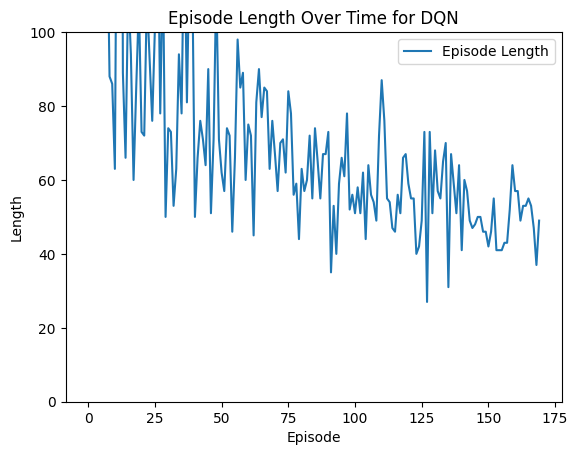

In [32]:
def plot_episode_lengths(episode_lengths, title="Episode Length Over Time"):
    plt.plot(episode_lengths, label="Episode Length")
    plt.xlabel("Episode")
    plt.ylabel("Length")
    plt.title(title)
    plt.legend()
    # y limit to avoid showing outliers
    plt.ylim(0, 100)
    plt.savefig("../images/training_images/episode_length_DDQN.png")
    plt.show()
    # save the image

print(step_history)

plot_episode_lengths(step_history, title="Episode Length Over Time for DQN")

# a2c

In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions, state_dim):
        super(ActorCritic, self).__init__()
        self.actor = self.create_actor_network(num_actions, state_dim)
        self.critic = self.create_critic_network(state_dim)

    def create_actor_network(self, num_actions, state_dim):
        actor = tf.keras.Sequential([
            Dense(128, activation='relu', input_shape=(state_dim,)),
            Dense(num_actions, activation='softmax')
        ])
        return actor

    def create_critic_network(self, state_dim):
        critic = tf.keras.Sequential([
            Dense(128, activation='relu', input_shape=(state_dim,)),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        return critic

    def call(self, state):
        policy_logits = self.actor(state)
        value = self.critic(state)
        return policy_logits, value

    def act(self, state):
        # convert state from (6,) to (None, 6)
        state = tf.expand_dims(state, 0)
        policy_logits = self.actor(state)
        action_probs = tf.nn.softmax(policy_logits)
        action = tf.random.categorical(action_probs, 1)
        return action

    def value(self, state):
        return self.critic(state)



## train

In [30]:

num_actions = 3
state_dim = 6  # 2D position + orientation + sensor readings
agent = ActorCritic(num_actions, state_dim)

# Compile the model
agent.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

# Create a buffer to store experiences
buffer = []
reward_history = []
loss_history = []
episode_path_history = []


env = RCMazeEnv()
# # Train the agent
# for episode in range(176):
#     state = env.reset()
#     done = False
#     rewards = 0
#     while not done:
#         # env.render(framerate=720, delay=0)
#         action = agent.act(state)
#         next_state, reward, done = env.step(action)
#         buffer.append((state, action, reward, next_state, done))
#         state = next_state
#         rewards += reward
#         episode_path_history.append((episode, env.car_position))
#     print(f"Episode {episode+1}, Reward: {rewards}")
#     reward_history.append(rewards)

#     print("Training the agent...")
#     print("Buffer length:", len(buffer))
#     if len(buffer) > 0:
#         for x in range(10):
#             try:
#                 states, actions, rewards, next_states, dones = zip(*buffer)
#                 states = tf.convert_to_tensor(states, dtype=tf.float32)
#                 actions = tf.convert_to_tensor(actions, dtype=tf.int32)
#                 rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
#                 next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
#                 dones = tf.convert_to_tensor(dones, dtype=tf.bool)

#                 with tf.GradientTape() as tape:
#                     policy_logits, values = agent(states)
#                     # policy_loss = tf.reduce_mean(
#                     #     tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=policy_logits)
#                     # )
#                     labels = actions
#                     labels = tf.reshape(labels, (-1,))
#                     policy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(labels, policy_logits)

#                     value_loss = tf.reduce_mean(tf.square(values - rewards))
#                     loss = policy_loss + value_loss
#                     loss_history.append(loss)
#                     print("Loss:", loss.numpy())

#                 gradients = tape.gradient(loss, agent.trainable_variables)
#                 agent.optimizer.apply_gradients(zip(gradients, agent.trainable_variables))

#                 buffer = []  # Reset the buffer
#             except Exception as e:
#                 # print(e)
#                 print("Error in training the agent")

# env.close_pygame()

for episode in range(176):
    state = env.reset()
    done = False
    rewards = 0
    buffer_episode = []  # Create a buffer for this episode
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        buffer_episode.append((state, action, reward, next_state, done))
        state = next_state
        rewards += reward
        episode_path_history.append((episode, env.car_position))
    print(f"Episode {episode+1}, Reward: {rewards}")
    reward_history.append(rewards)

    # Add the episode buffer to the main buffer
    buffer.extend(buffer_episode)

    print("Training the agent...")
    print("Buffer length:", len(buffer))
    if len(buffer) > 0:
        for x in range(10):
            batch_size = 256
            indices = np.random.choice(len(buffer), batch_size, replace=False)
            batch = [buffer[i] for i in indices]

            states, actions, rewards, next_states, dones = zip(*batch)
            # states = tf.convert_to_tensor(states, dtype=tf.float32)
            # actions = tf.convert_to_tensor(actions, dtype=tf.int32)
            # rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
            # next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
            # dones = tf.convert_to_tensor(dones, dtype=tf.bool)

            states = tf.stack([tf.convert_to_tensor(state, dtype=tf.float32) for state in states])
            actions = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.stack([tf.convert_to_tensor(state, dtype=tf.float32) for state in next_states])
            dones = tf.convert_to_tensor(dones, dtype=tf.bool)

            with tf.GradientTape() as tape:
                policy_logits, values = agent(states)
                labels = actions
                labels = tf.reshape(labels, (-1,))
                policy_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(labels, policy_logits)

                value_loss = tf.reduce_mean(tf.square(values - rewards))
                loss = policy_loss + value_loss
                loss_history.append(loss)
                # print("Loss:", loss.numpy())

            gradients = tape.gradient(loss, agent.trainable_variables)
            agent.optimizer.apply_gradients(zip(gradients, agent.trainable_variables))

            buffer = [x for i, x in enumerate(buffer) if i not in indices]  # Remove the used samples from the buffer
            # print("Buffer length after training:", len(buffer))

env.close_pygame()

Episode 1, Reward: -34109.72232728788
Training the agent...
Buffer length: 3001
Episode 2, Reward: -34109.72232728788
Training the agent...
Buffer length: 3442
Episode 3, Reward: -34109.72232728788
Training the agent...
Buffer length: 3883
Episode 4, Reward: -34109.72232728788
Training the agent...
Buffer length: 4324
Episode 5, Reward: -34109.72232728788
Training the agent...
Buffer length: 4765
Episode 6, Reward: -34109.72232728788
Training the agent...
Buffer length: 5206
Episode 7, Reward: -34109.72232728788
Training the agent...
Buffer length: 5647


KeyboardInterrupt: 

## test

In [5]:
# test the agent

env = RCMazeEnv()
state = env.reset()
done = False
rewards = 0
path = []
while not done:
    env.render(framerate=60, delay=0)
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    path.append(env.car_position)
    rewards += reward
    state = next_state
print("Test reward:", rewards)
env.close_pygame()


KeyboardInterrupt: 

In [ ]:
# plot path
from matplotlib import pyplot as plt

def plot_path(path, maze):
    plt.imshow(maze, cmap="binary")
    x, y = zip(*path)
    plt.plot(x, y, marker="o", color="r", markersize=5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

plot_path(path, env.maze)


## results

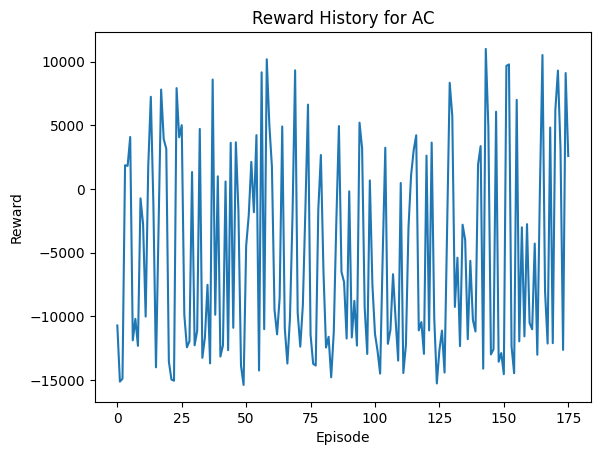

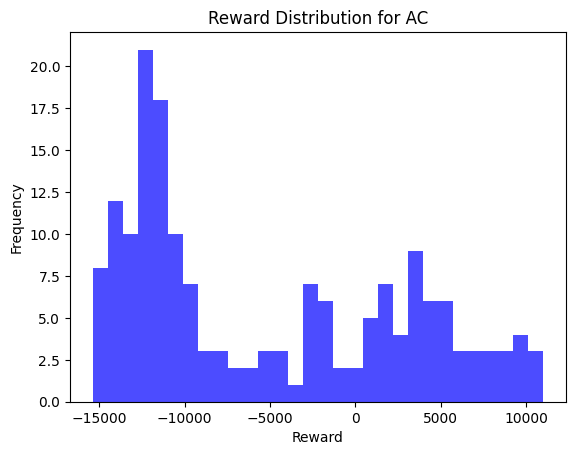

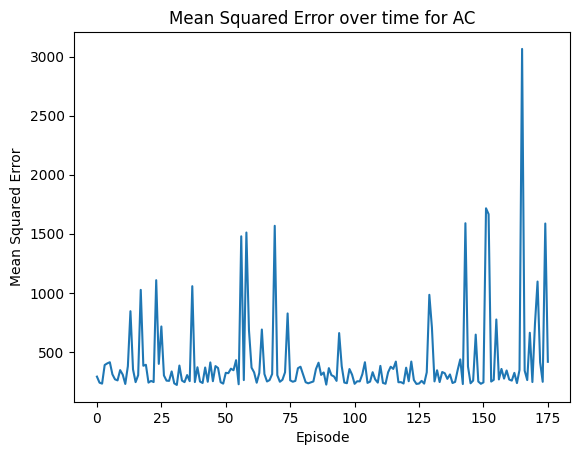

In [9]:

# plot the reward history
plt.plot(reward_history)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward History for AC")
plt.savefig('../images/training_images/reward_history_AC.png')
plt.show()
# save the image
def plot_reward_distribution(rewards, title="Reward Distribution"):
    plt.hist(rewards, bins=30, alpha=0.7, color="blue")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.savefig("../images/training_images/reward_distribution_AC.png")
    plt.show()
    # save the image


# Example usage:
# Assuming `rewards` is a list of total rewards per episode.
# plot_reward_distribution(rewards)
plot_reward_distribution(reward_history, title="Reward Distribution for AC")
# plot epsilon over time
# plt.plot(epsilon_history)
# plt.xlabel('Episode')
# plt.ylabel('Epsilon')
# plt.title("Epsilon History for AC")
# plt.savefig("../images/training_images/epsilon_history_AC.png")
# plt.show()
# # save the image
# evalution

# plot mse
plt.plot(loss_history)
plt.xlabel('Episode')
plt.ylabel('Mean Squared Error')
plt.title("Mean Squared Error over time for AC")
plt.savefig("../images/training_images/mse_history_AC.png")
plt.show()
# save the image
# save model
# agent.save('../models/AC_RCmaze_v3.h5')
import numpy as np
import matplotlib.pyplot as plt



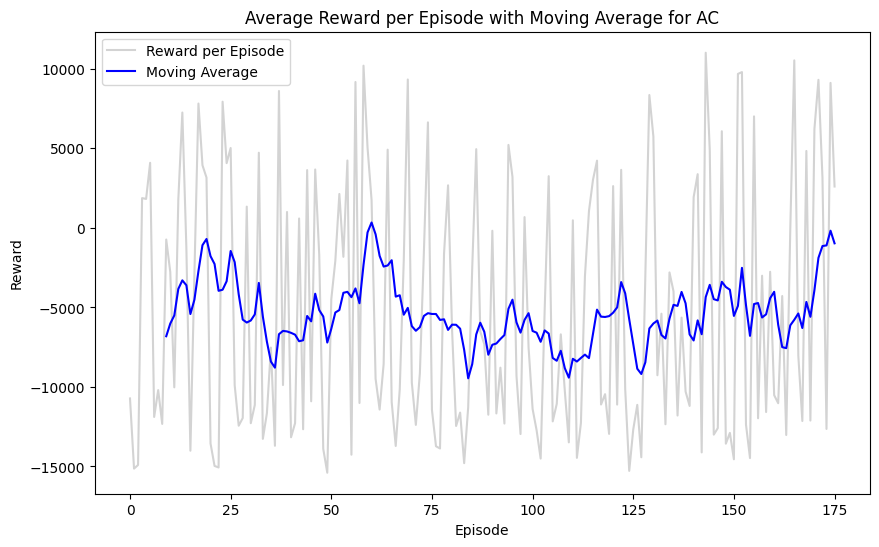

In [10]:
# plot moving average
window_size = 10
moving_avg = np.convolve(reward_history, np.ones(window_size) / window_size, mode="valid")

low_point = np.argmin(moving_avg)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(reward_history, label="Reward per Episode", color="lightgray")
plt.plot(
    range(window_size - 1, len(reward_history)),
    moving_avg,
    label="Moving Average",
    color="blue",
)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average Reward per Episode with Moving Average for AC")
plt.legend()
plt.savefig("../images/training_images/reward_per_episode_with_moving_avg_AC.png")
plt.show()


[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1]
 [-1  0 -1  0  0  0  0  0  0  0  0 -1]
 [-1  0 -1  0 -1 -1 -1 -1 -1 -1  0 -1]
 [-1  0 -1  0 -1 -1  0  0  0  0  0 -1]
 [-1  0  0  0 -1 -1  0 -1 -1 -1 -1 -1]
 [-1  0 -1  0  0  0  0 -1  0 -1 -1 -1]
 [-1  0 -1 -1  0 -1  0  0  0  0  0 -1]
 [-1  0 -1  0  0 -1 -1 -1 -1 -1  0 -1]
 [-1  0  0  0 -1 -1  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


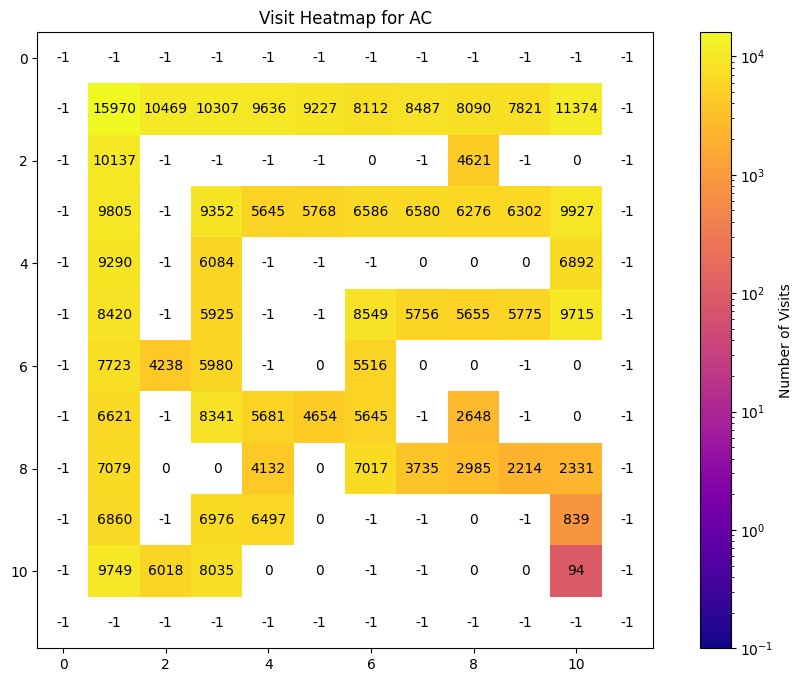

: 

In [11]:
# convert to dictionary
episode_path_dict = {}
for episode, position in episode_path_history:
    if episode in episode_path_dict:
        episode_path_dict[episode].append(position)
    else:
        episode_path_dict[episode] = [position]

maze = env.maze

visit_counts = np.zeros((maze.shape[0], maze.shape[1]), dtype=int)

visit_counts[env.maze == 1] = -1
print(visit_counts)


for episode, path in episode_path_dict.items():
    for position in path:
        visit_counts[position] += 1

from math import nan
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, LogNorm


def plot_visit_heatmap(visit_counts, title="Visit Heatmap"):
    # Transpose visit_counts to match the expected orientation
    visit_counts_transposed = visit_counts.T  # Transpose the matrix

    # Filter out the wall cells by setting their count to NaN for visualization
    filtered_counts = np.where(
        visit_counts_transposed == -1, np.nan, visit_counts_transposed
    )

    # Define a continuous colormap (you can choose any colormap you like)
    cmap = plt.cm.plasma
    cmap.set_bad("white")  # Use gray for NaN (walls)
    plt.figure(figsize=(12, 8))
    # Use LogNorm for logarithmic normalization; set vmin to a small value > 0 to handle cells with 0 visits
    plt.imshow(
        filtered_counts,
        cmap=cmap,
        norm=LogNorm(vmin=0.1, vmax=np.nanmax(filtered_counts)),
        interpolation="nearest",
    )
    # add the nr of visits to the cells
    for i in range(visit_counts_transposed.shape[0]):
        for j in range(visit_counts_transposed.shape[1]):
            if visit_counts_transposed[i, j] != -1 or visit_counts_transposed[i, j] != nan:
                plt.text(j, i, visit_counts_transposed[i, j], ha="center", va="center")

    plt.colorbar(label="Number of Visits")
    plt.title(title)
    plt.savefig("../images/training_images/visit_heatmap_AC.png")
    plt.show()
    # save the image


plot_visit_heatmap(visit_counts, title="Visit Heatmap for AC")

